In [29]:
#Import necessary libraries
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
import numba
from numba import njit

In [30]:
# Create B clBss to represent letter pairs and their composite relationships
class CompositeElement:
    def __init__(self, name):
        self.name = name
        self._composite = None
    
    def composite(self):
        return self._composite
    
    def set_composite(self, other):
        self._composite = other

class CompositeMapping:
    def __init__(self):
        self.elements = {}
    
    def add_pair(self, element1, element2):
        # Create CompositeElement instances if they don't exist
        if element1 not in self.elements:
            self.elements[element1] = CompositeElement(element1)
        if element2 not in self.elements:
            self.elements[element2] = CompositeElement(element2)
        
        # Set up the composite relationship
        self.elements[element1].set_composite(self.elements[element2])
        self.elements[element2].set_composite(self.elements[element1])
    
    def get_element(self, name):
        return self.elements.get(name)





def create_mapping():# Check encoding first
    
    # Create a composite mapping
    composite_mapping = CompositeMapping()
    
    # Define all the letter sets
    latin_upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    latin_lower = 'abcdefghijklmnopqrstuvwxyz'

    
    # Define Latin names
    latin_names_upper = [
        'ALPHA', 'BETA', 'GAMMA', 'DELTA', 'EPSILON', 'ZETA', 'ETA', 'THETA',
        'IOTA', 'KAPPA', 'LAMBDA', 'MU', 'NU', 'XI', 'OMICRON', 'PI', 'RHO',
        'SIGMA', 'TAU', 'UPSILON', 'PHI', 'CHI', 'PSI', 'OMEGA'
    ]
    latin_names_lower = [name.lower() for name in latin_names_upper]

    
    
    # 1. Latin uppercase to uppercase prime
    for letter in latin_upper:
        composite_mapping.add_pair(letter, f"{letter}_prime")
    
    # 2. Latin lowercase to lowercase prime
    for letter in latin_lower:
        composite_mapping.add_pair(letter, f"{letter}_prime")
    
    
    # 5. Latin names uppercase to uppercase prime
    for name in latin_names_upper:
        composite_mapping.add_pair(name, f"{name}_prime")
    
    # 6. Latin names lowercase to lowercase prime
    for name in latin_names_lower:
        composite_mapping.add_pair(name, f"{name}_prime")

    # 7. Numbers to uppercase prime
    for number in range(1, 100):
        composite_mapping.add_pair(str(number), f"{str(number)}_prime")
    composite_mapping.add_pair('SIX','SIX')
    
    return composite_mapping


    
composite_mapping=create_mapping()

In [31]:
# Function to get the inverse composite of a sequence, takes a sequence of names and returns the corresponding composite names in reverse order

# def inverse_composite(sequence):
#     inverse_composite=sequence[::-1]
#     for i in range(len(inverse_composite)):
#         inverse_composite[i]=composite_mapping.elements[inverse_composite[i]]._composite.name
#     return inverse_composite
@njit
def inverse_composite(sequence):
    inverse_composite=sequence[::-1]
    for i in range(len(inverse_composite)):
        if inverse_composite[i].islower():
            inverse_composite[i]=inverse_composite[i].upper()
        elif inverse_composite[i].isupper():
            inverse_composite[i]=inverse_composite[i].lower()
    return inverse_composite

In [32]:
# Function to define deletion and inversion operations,takes a DNA sequence and two sites, and returns the modified sequence
@njit
def delete_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+DNA[site_2:]  
@njit
def invert_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+inverse_composite(DNA[site_1-1:site_2])+DNA[site_2:] 

In [33]:
# Functions to detect sites in a DNA sequence, takes a DNA sequence and a site, and returns the start positions of the sites and the direction (forward or backward)
@njit
def detect_pair_BRA(DNA,site):
    site_length = len(site)
    start_positions = []
    
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        DNA_window=DNA[i:i+site_length]
        if DNA_window == site:
            start_positions.append((i,'forward'))#computer positions
        elif DNA_window == inverse_composite(site):
            start_positions.append((i,'backward'))#computer positions

    
    return start_positions
@njit
def detect_pair_KET(DNA,site):
    site_length = len(site)
    start_positions = []
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        DNA_window=DNA[i:i+site_length]
        if DNA_window == site:
            start_positions.append((i,'forward'))#computer positions
        elif DNA_window == inverse_composite(site):
            start_positions.append((i,'backward'))#computer positions
    
    return start_positions


In [34]:
# Function to evaluate the colour of a DNA sequence based on two choices, takes a DNA sequence and two choices (each with a number and direction) and returns the modified sequence

def evaluate_colour_IS110(DNA,choice1,choice2):

    num1, direction_1 = choice1
    num2, direction_2 = choice2
    #WLOG,make num 1 the smaller one
    if num1 > num2:
        num1, num2 = num2, num1
        direction_1, direction_2 = direction_2, direction_1
    # Determine which function to use
    
    if direction_1 == 'forward':
        if direction_1 == direction_2:
            result= delete_between(DNA,num1+2,num2+1)
        elif direction_1!=direction_2:
            result= invert_between(DNA,num1+2,num2+1)
    elif direction_1=='backward':
        if direction_1 == direction_2:
            result= delete_between(DNA,num1+2,num2+1)
        else :
            result= 'DoNotCount'
            #result= invert_between(DNA,num1+2,num2+1)
    if choice1==choice2:
        result='DoNotCount'
    return result

In [35]:
# Function to calculate the probabilities of different outcomes based on a DNA sequence and a pool of pairs
# Takes a DNA sequence, a pool of pairs, and the number of events, and returns a list called 'outcome_lists' containing Counters object that record the probabilities for each stage of the process

In [36]:
# ***What an outcome list looks like***


# [Counter({('1',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4',
#            'ALPHA_prime',
#            'A_prime'): 1}),

#  Counter({('1',
#            'A',
#            'ALPHA',
#            '2_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4',
#            'ALPHA_prime',
#            'A_prime'): 0.2,
#           ('1', 'A', 'ALPHA', '4', 'ALPHA_prime', 'A_prime'): 0.2,
#           ('1',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3_prime',
#            'A',
#            'ALPHA',
#            '2_prime',
#            'ALPHA_prime',
#            'A_prime'): 0.2,
#           ('1', 'A', 'ALPHA', '2', 'ALPHA_prime', 'A_prime'): 0.2,
#           ('1',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime'): 0.2}),
           
#  Counter({('1', 'A', 'ALPHA', '2_prime', 'ALPHA_prime', 'A_prime'): 0.28,
#           ('1', 'A', 'ALPHA', '4_prime', 'ALPHA_prime', 'A_prime'): 0.28,
#           ('1',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4',
#            'ALPHA_prime',
#            'A_prime'): 0.12,
#           ('1',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3_prime',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime'): 0.08})]

In [37]:
#Calculate the possibe DNA sequences follwing one recombinases event from one input
def calculate_each_input(dna, pairs_pool, print_output=0, print_T=0):
    """
    Parameters:
    dna (list): The DNA sequence represented as a list of names.
    pairs_pool (list): A list of pairs of sites to be processed.
    print_output (int): If 1, print the output for each recombinase action.
    print_T (int): If 1, print a message when a terminal state is reached.
    
    Returns:
    tuple: A tuple containing the result Counter and the normalization factor.
    """
    thisinput = Counter()
    recombinase_acted = 0
    for pair in pairs_pool:
        #print(pair)
        BRA_sites=pair[0]
        KET_sites=pair[1]

        BRA_positions=detect_pair_BRA(dna,BRA_sites)
        KET_positions=detect_pair_KET(dna,KET_sites)

        
        for i in range(len(BRA_positions)):
            for j in range(len(KET_positions)):
                choice1,choice2 = BRA_positions[i], KET_positions[j]
                #print(choice1,choice2)
                output = evaluate_colour_IS110(dna,choice1,choice2)
                formatted_output = tuple(output)
                if print_output==1:
                    
                    print(formatted_output)
                if output!='DoNotCount':
                    recombinase_acted += 1
                    

                    #print(f"stage {whichstage} dna {dna} recombinase {recombinase_acted} output: {formatted_output}")  # !!!Remove before flight

                    thisinput[formatted_output] +=1
        #print(recombinase_acted)
    if recombinase_acted==0:
            normfactor = 1
            thisinput[tuple(dna)] = 1
            if print_T==1:
                print(tuple(dna), "Terminal state reached, no recombinase acted")
    else:
            normfactor = recombinase_acted
    return thisinput, normfactor

In [38]:
#Iterate through the DNA sequences at each stages and calculate the result 
def probability_calculation_IS110(DNA,pairs_pool,numberofevents=1,print_output=0,print_T=0):
    outcome_list=[]

    for _ in range(numberofevents):
        outcome_list.append(Counter())
    

    outcome_list[0][tuple(DNA)] = 1

    # Iterate through each stage and calculate the outcomes
    for whichstage in range(1,numberofevents):

        stage = outcome_list[whichstage-1]
        for dna,probs in stage.items():
            dna=list(dna)
            # Now work out all the things the recombinases can do
            thisinput, normfactor=calculate_each_input(dna, pairs_pool, print_output, print_T)
                
            for key in thisinput:
                outcome_list[whichstage][key] += thisinput[key]*probs/normfactor

    # Check to see if normalisation is preserved
        #print(f"Stage {whichstage} has {len(outcome_list[whichstage])} outcomes")
    return outcome_list
    


In [39]:
# Visualisation function to plot ranked probability distributions after each recombination event


def plot_ranked_probabilities(outcome_list):
    for stage in range(len(outcome_list)):
        probs = np.array(sorted(outcome_list[stage].values(), reverse=True))
        ranks = np.arange(1, len(probs) + 1)
        
        # Create a single figure with 1 row and 3 columns of subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        fig.suptitle(f'Stage {stage}: Ranked Probabilities', y=1.05)
        
        # Plot 1: Linear scale
        axes[0].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[0].set_xlabel('Rank')
        axes[0].set_ylabel('Probability')
        axes[0].set_yscale('linear')
        axes[0].set_title('Linear Scale')
        
        # Plot 2: Log-y scale
        axes[1].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[1].set_xlabel('Rank')
        axes[1].set_ylabel('Probability')
        axes[1].set_yscale('log')
        axes[1].set_title('Log-Y Scale')
        
        # Plot 3: Log-log scale
        axes[2].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[2].set_xlabel('Rank')
        axes[2].set_ylabel('Probability')
        axes[2].set_yscale('log')
        axes[2].set_xscale('log')
        axes[2].set_title('Log-Log Scale')
        
        plt.tight_layout()
        plt.show()

In [40]:
# Visualisation function to plot the probabilities sum and entropy of outcomes at each stage
def plot_probabilities(outcome_list, numberofevents=1,rank=0):    
    probsum = 0
    num_of_possible_outcomes = np.zeros(numberofevents)
    total_num_of_outcomes = np.zeros(numberofevents)
    entropy = np.zeros(numberofevents)
    initial_dict=Counter()
    for stage in range(numberofevents):
        probsum = np.sum(list(outcome_list[stage].values()))
        if (probsum-1)> 0.01 or (probsum-1)<-0.01:
            raise ValueError(f"Stage {stage} does not sum to 1, it sums to {probsum}. Please check the input data or the calculation logic.")
        entropy[stage] = -np.sum([p * np.log2(p) for p in outcome_list[stage].values() if p > 0])
        num_of_possible_outcomes[stage] = len(outcome_list[stage])
        initial_dict.update(outcome_list[stage])
        total_num_of_outcomes[stage] = len(initial_dict)

    # # Plot normalisation
    # plt.figure(figsize=(6, 3))
    # plt.plot(probsum, marker='o', linestyle='-', color='k')
    # plt.xlabel('Stage')
    # plt.ylabel('Sum of Probabilities')
    # #plt.ylim(0, 1.1)

    # Plot number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(num_of_possible_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Number of Possible Outcomes occuring at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot cumulative number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(total_num_of_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Cumulative number of Possible Outcomes at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot entropy
    plt.figure(figsize=(6, 3))
    plt.plot(entropy, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Entropy')
    #plt.ylim(0, np.max(entropy) * 1.1)

    # Plot ranked probabilities
    plot_ranked_probabilities(outcome_list) if rank==1 else None

    


In [41]:
#A function that packs the probability calculation and plotting functions together, takes a DNA sequence, a pool of pairs, and the number of events, and returns the outcome lists
def run_probability_calculation_and_plot_IS110(DNA_sequence, pairs_pool, numberofevents=1, print_output=0, print_T=0,rank=0,plot=0):
    outcome_list = probability_calculation_IS110(DNA_sequence, pairs_pool, numberofevents, print_output, print_T)
    plot_probabilities(outcome_list, numberofevents,rank=rank) if plot==1 else None
    return outcome_list

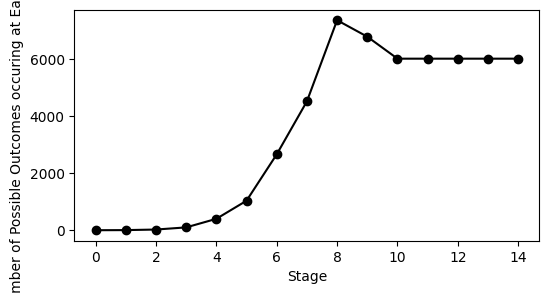

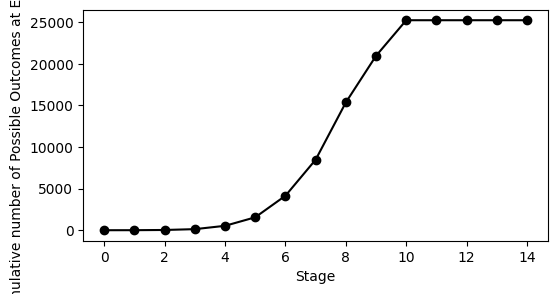

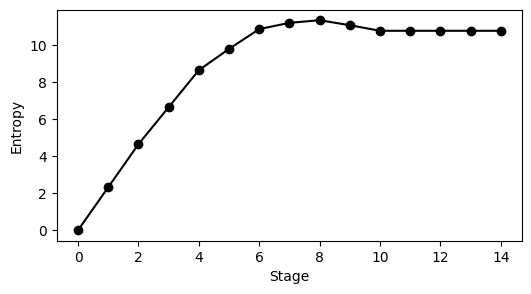

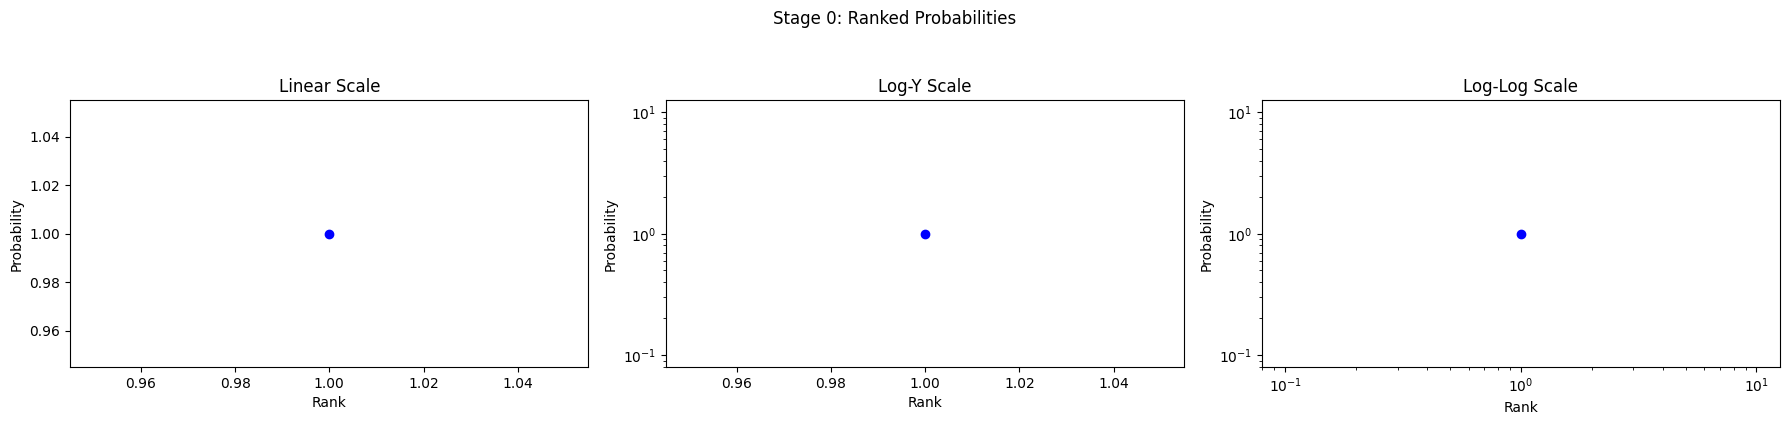

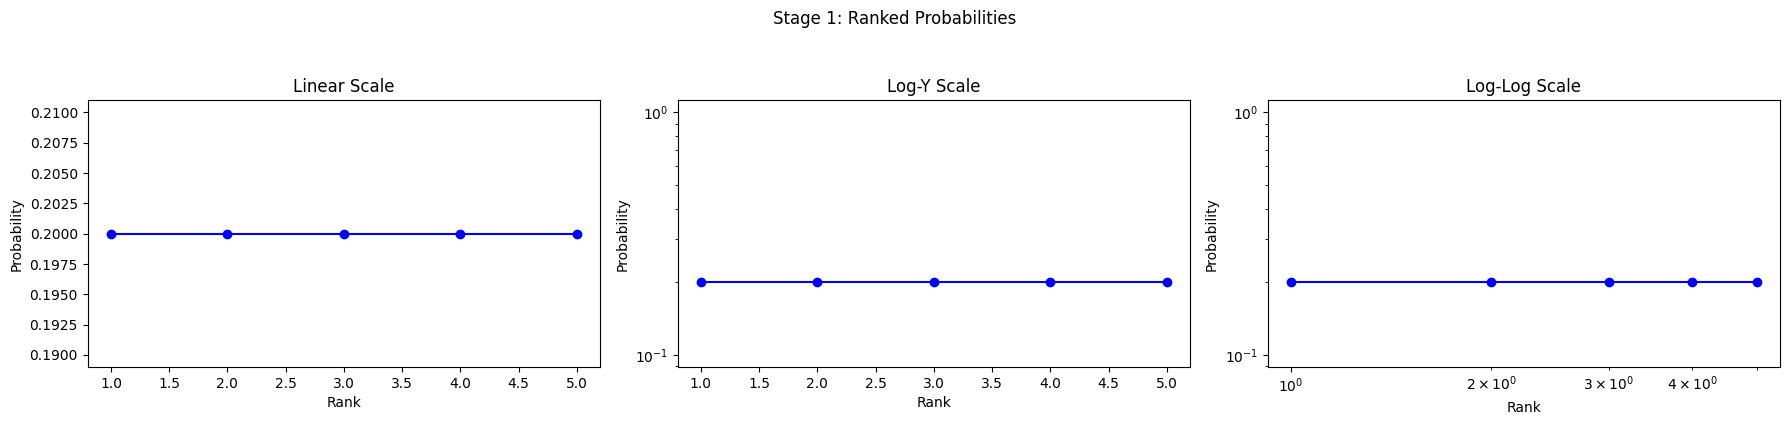

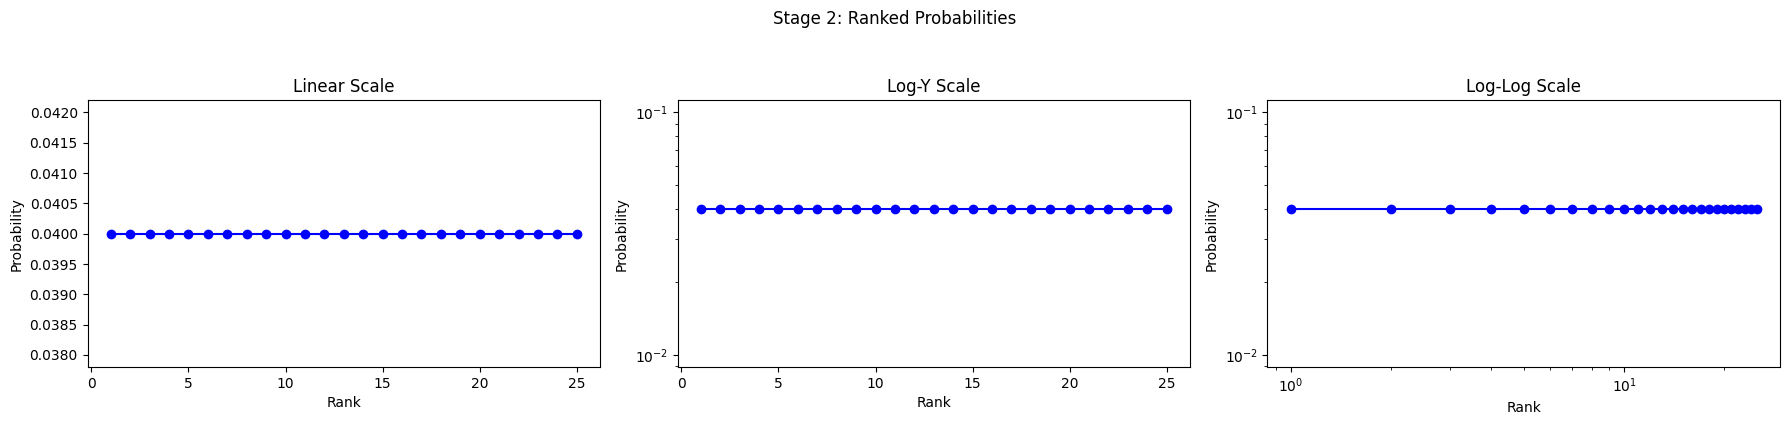

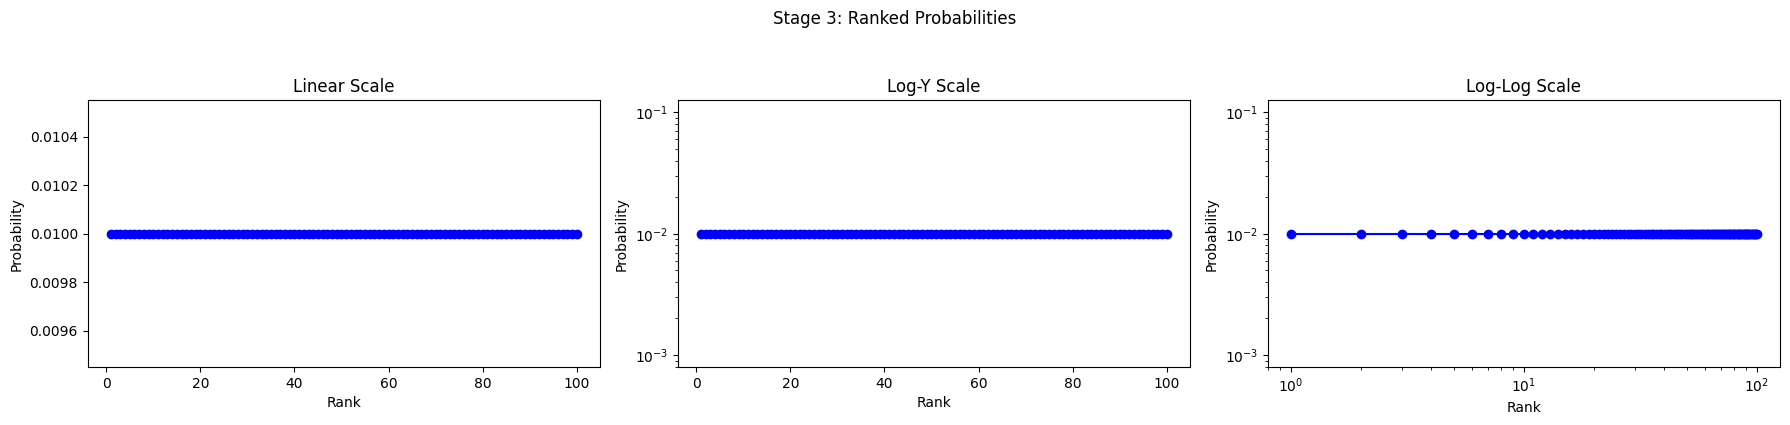

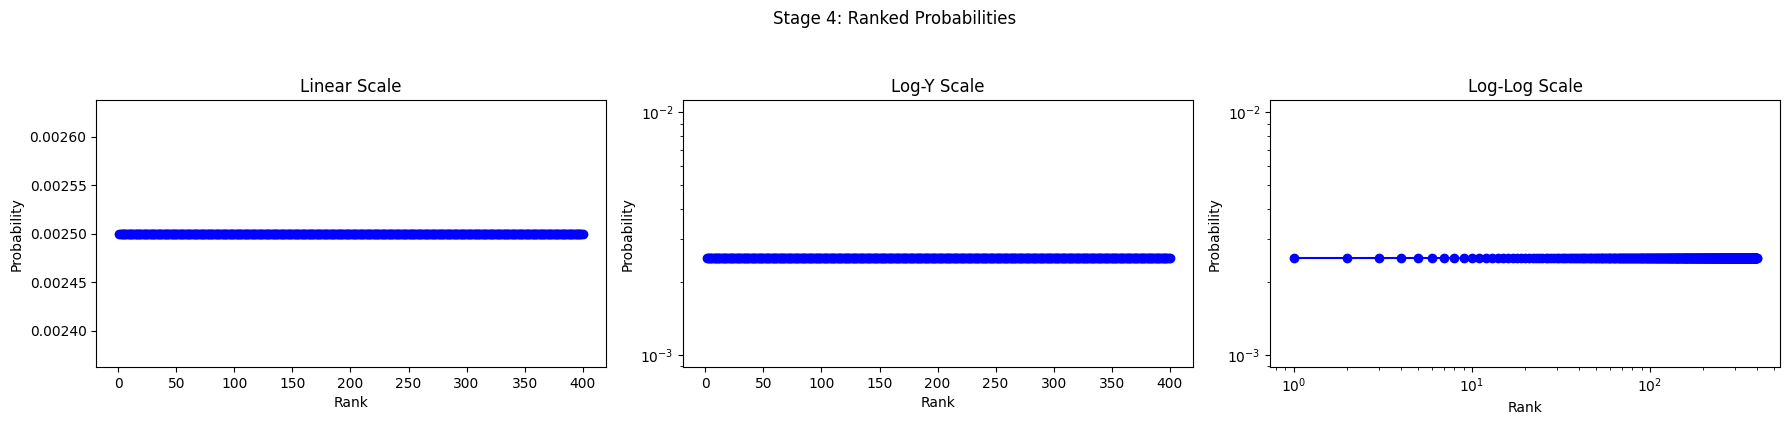

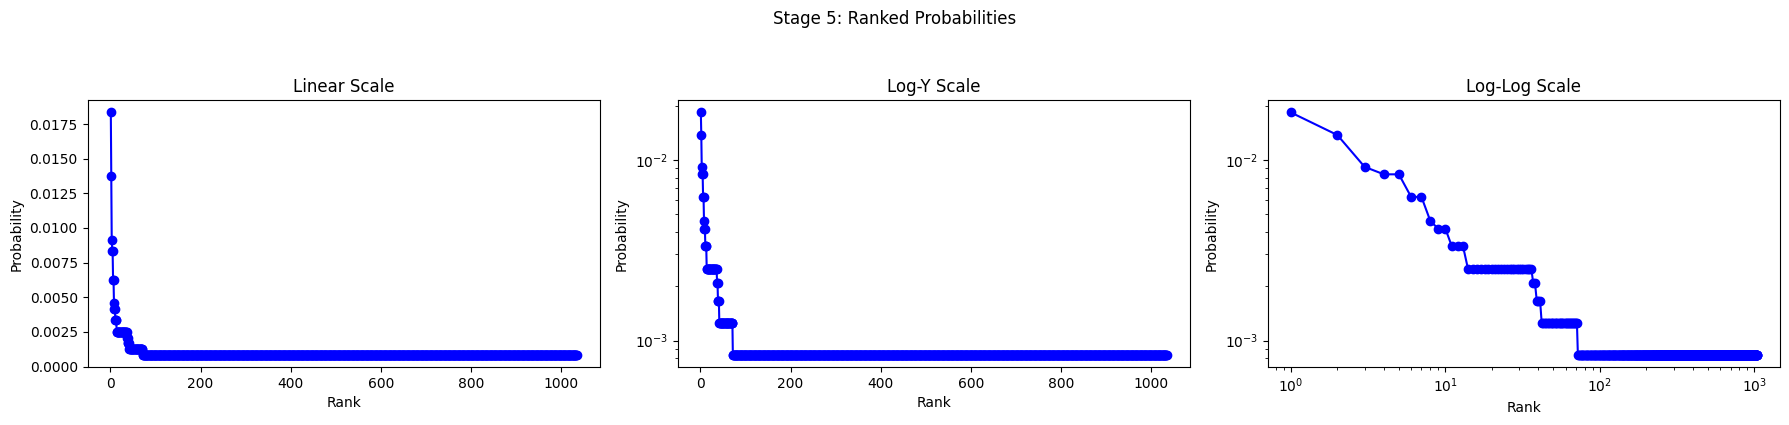

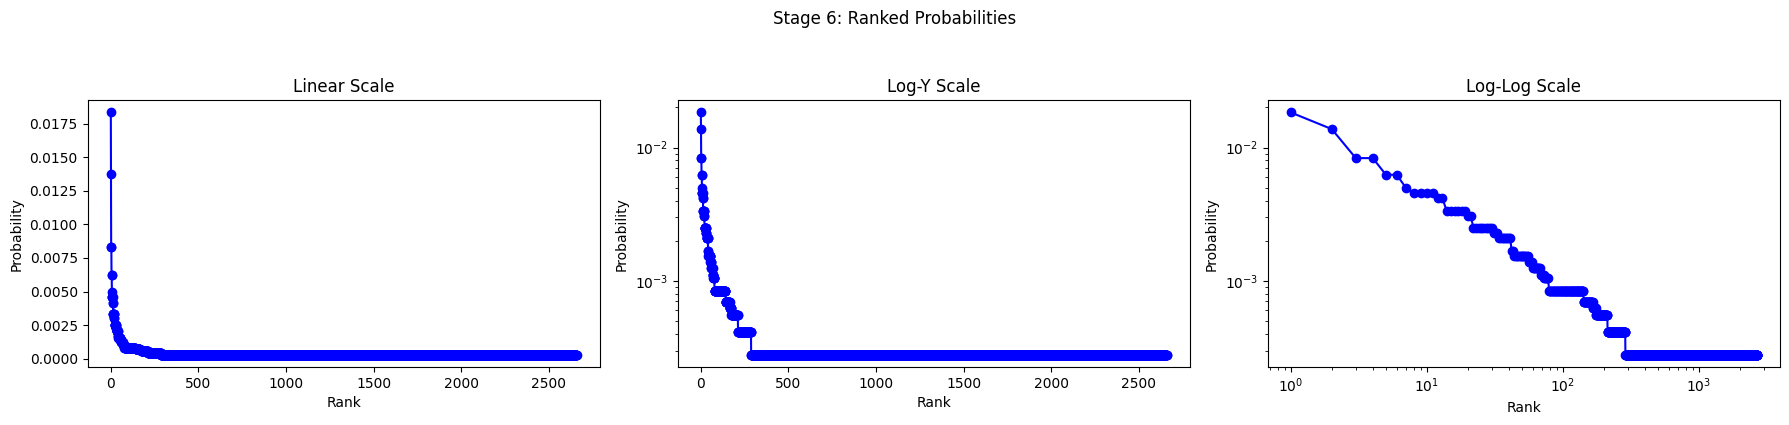

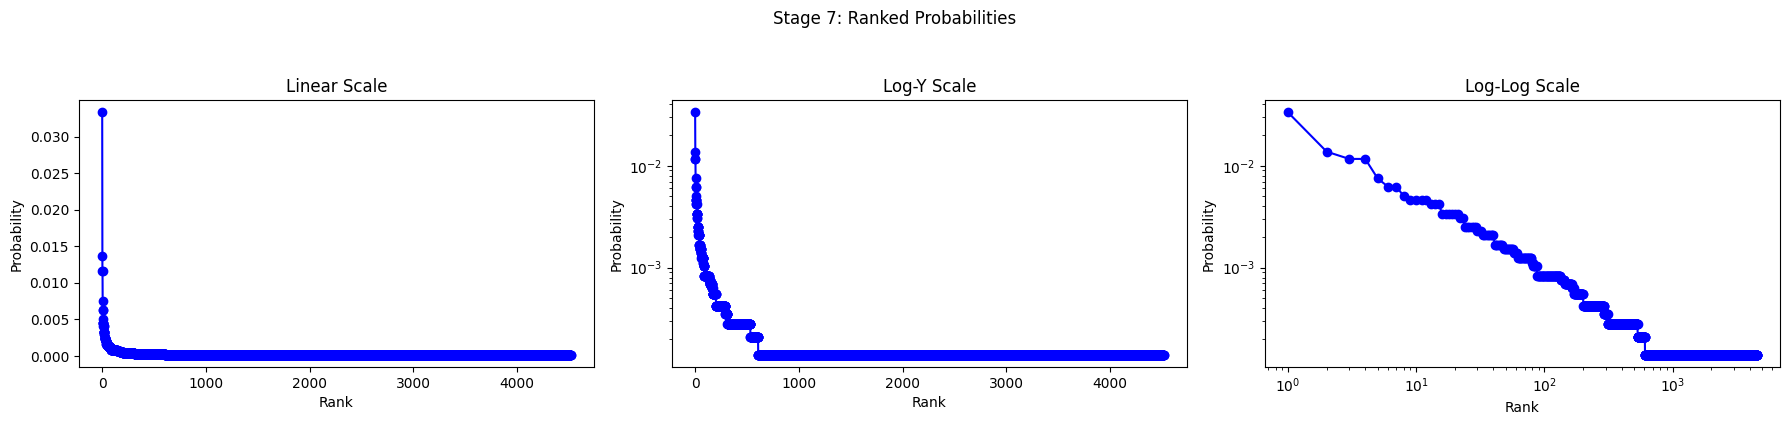

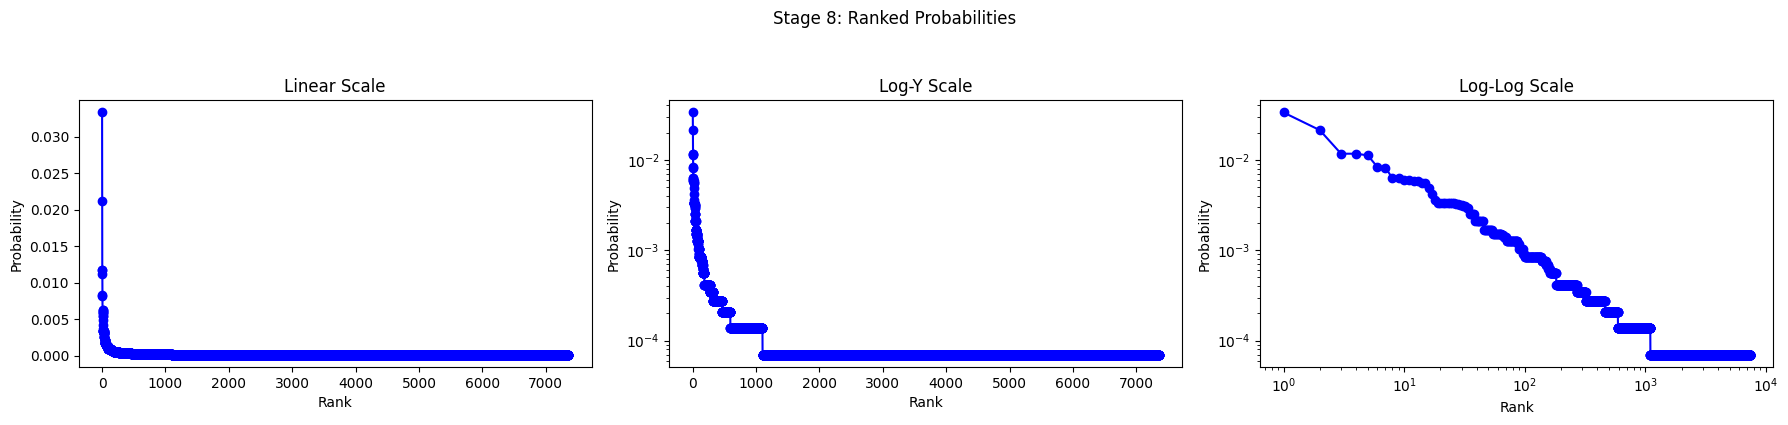

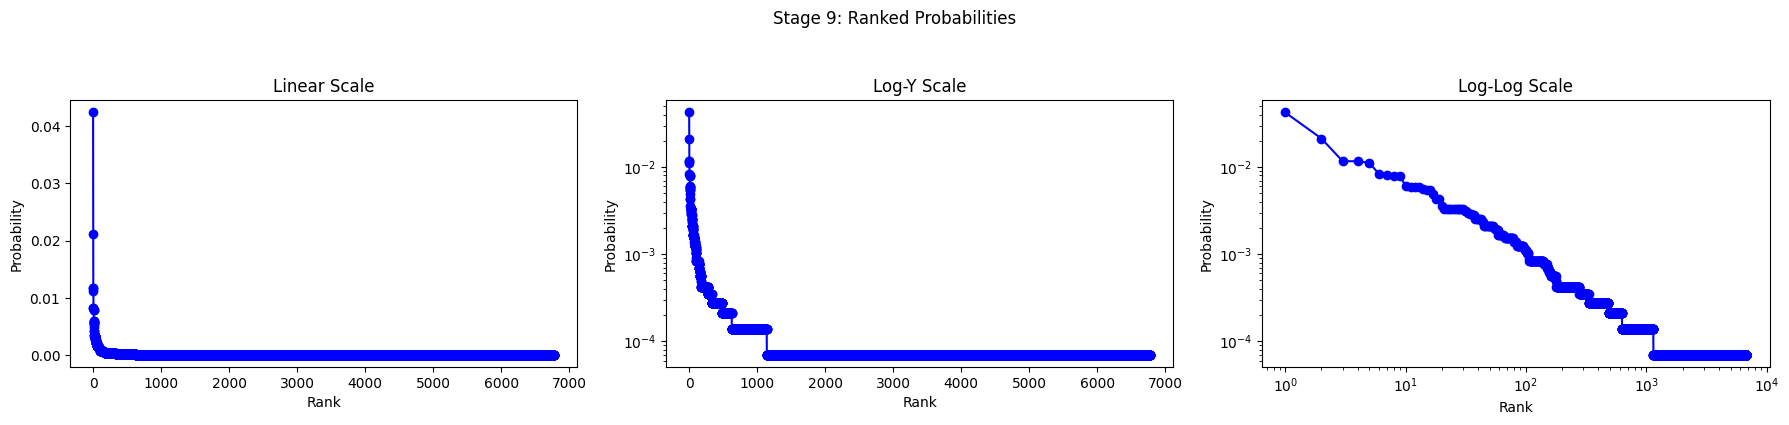

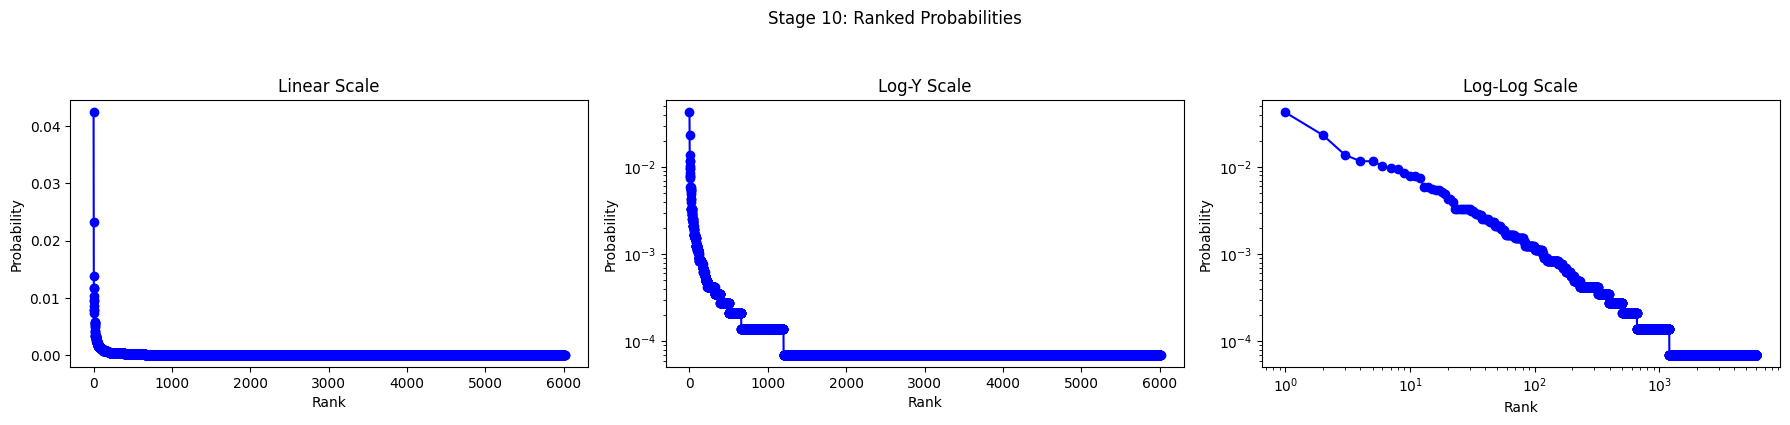

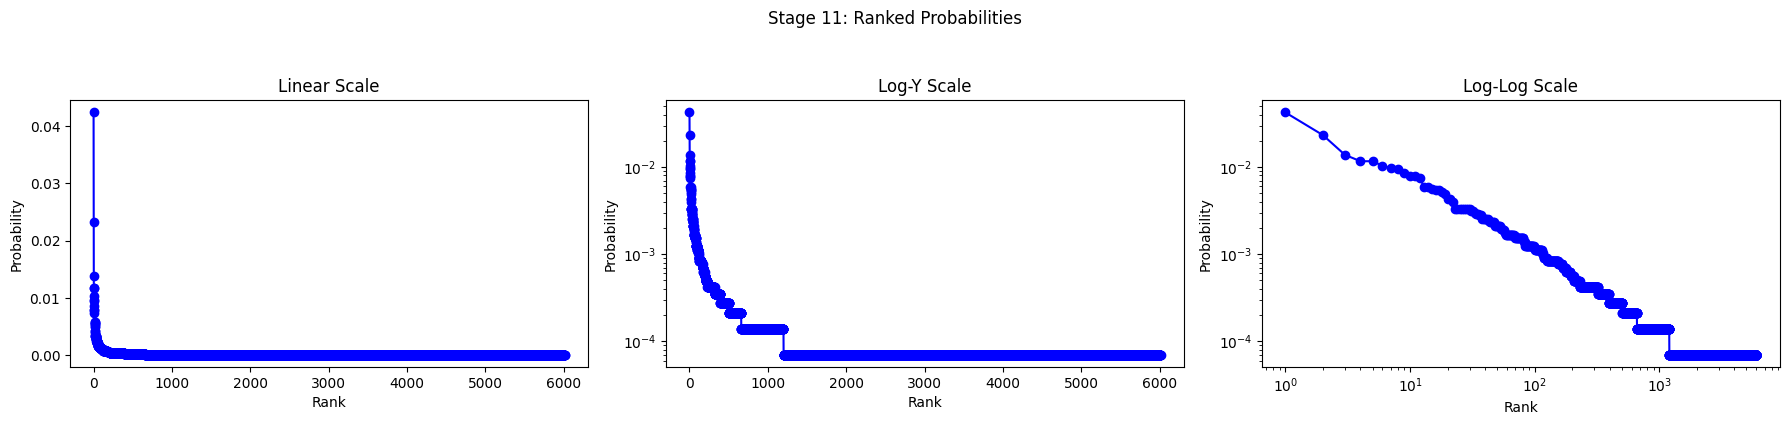

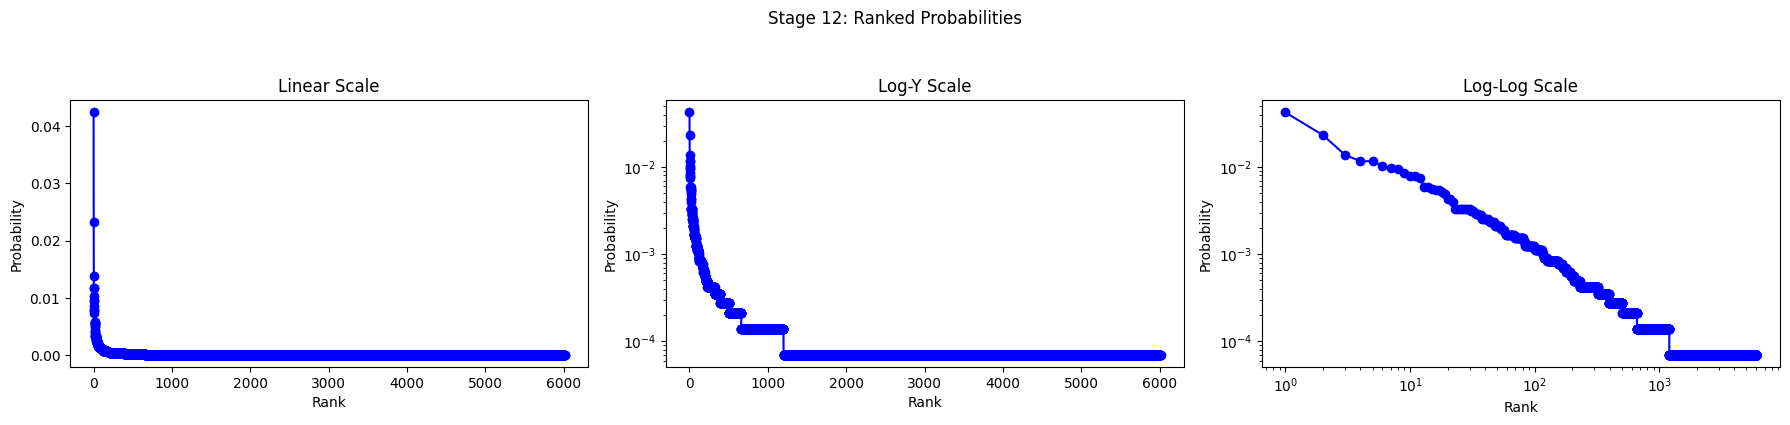

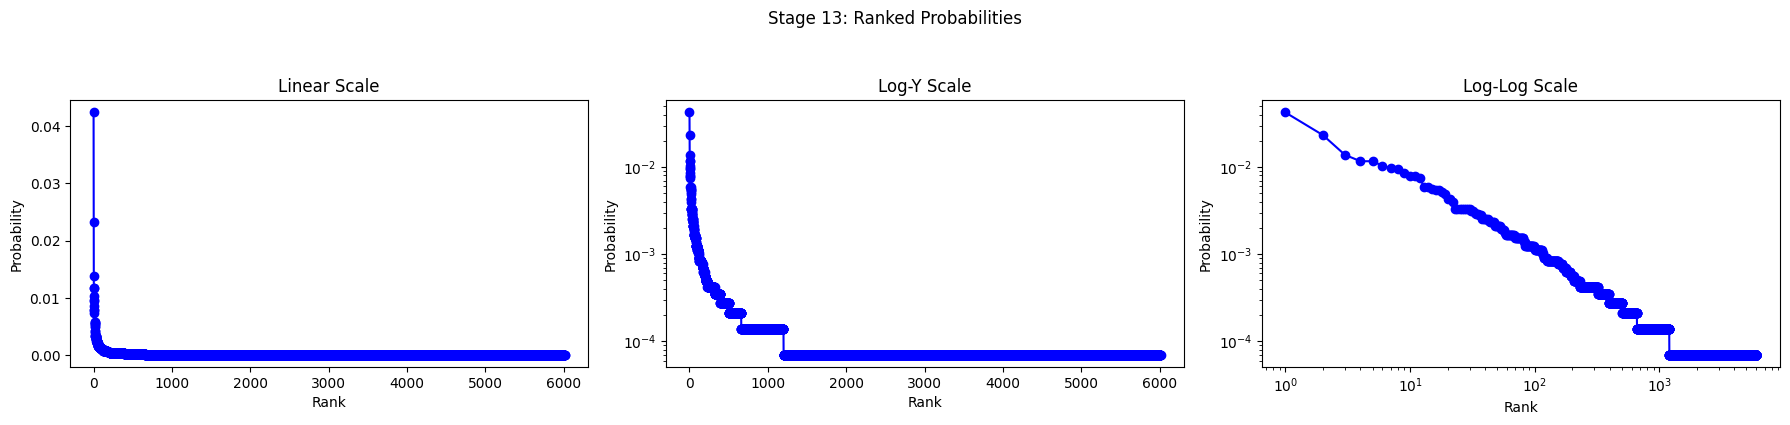

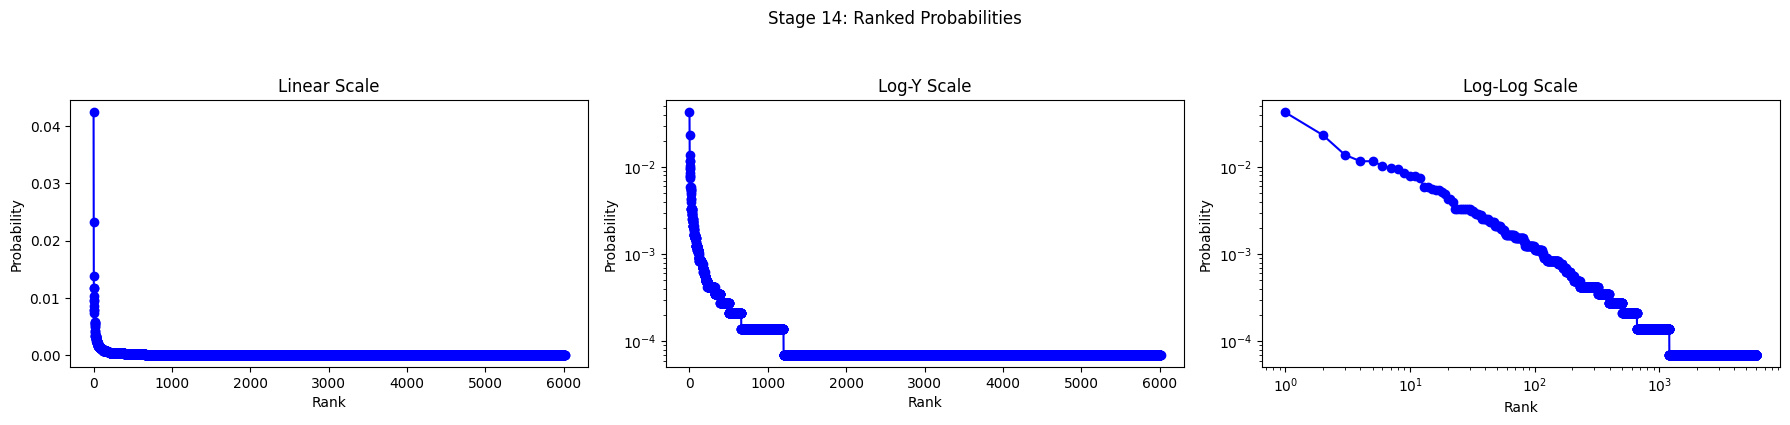

In [42]:
#Sequence with single active site
DNA_sequence=[
'ONE', 'A', 'ALPHA',
'TWO','A','ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE','A','ALPHA',
'SIX', 'A', 'GAMMA',
'SEVEN','beta', 'b',
'EIGHT','beta', 'b',
'NINE','beta', 'b',
'TEN','beta', 'b',
'ELEVEN','beta', 'b',

]
pairs_pool=[(['A','GAMMA'],['B','BETA']),(['A','ALPHA'],['B','GAMMA'])]
outcome_lists_1= run_probability_calculation_and_plot_IS110(DNA_sequence,pairs_pool,numberofevents=15,plot=1,rank=1)


Reverse starts here


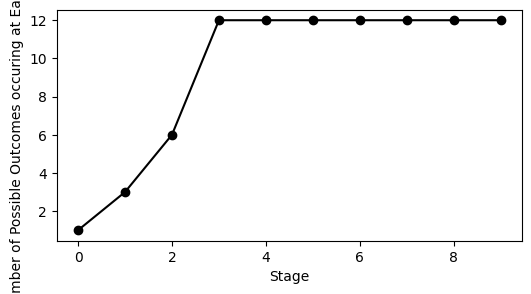

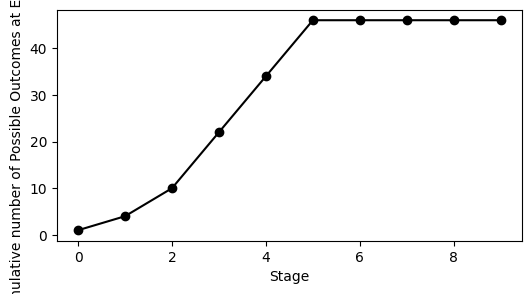

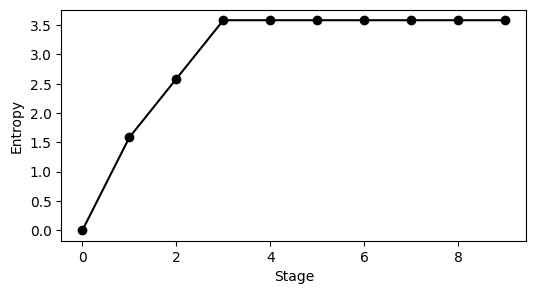

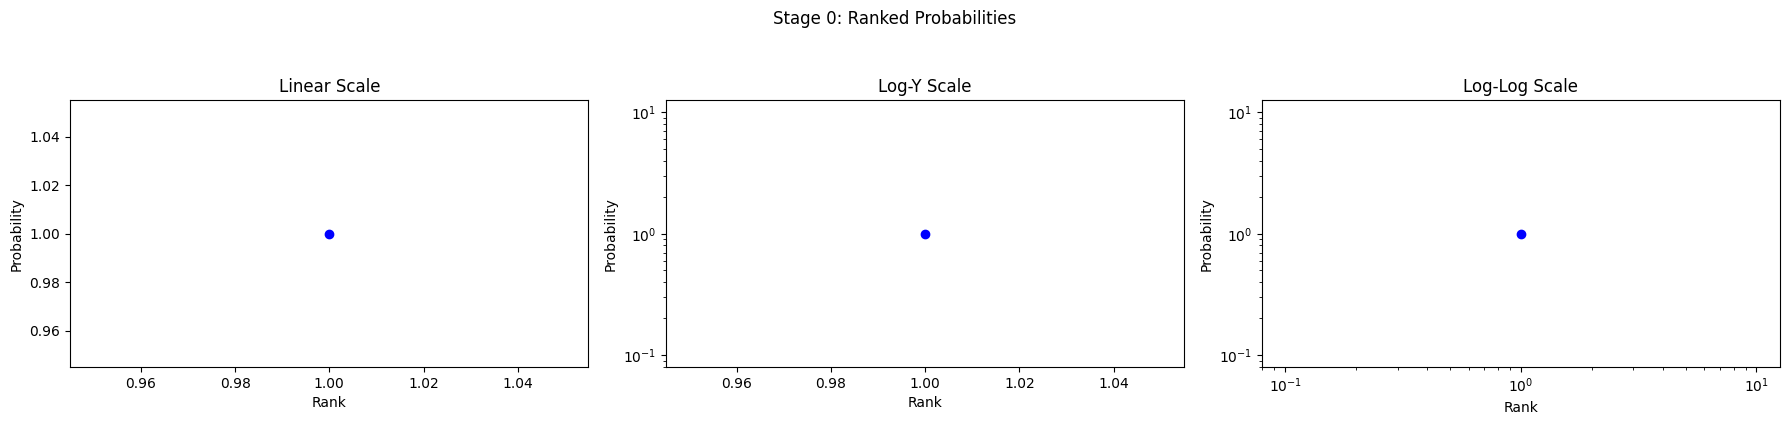

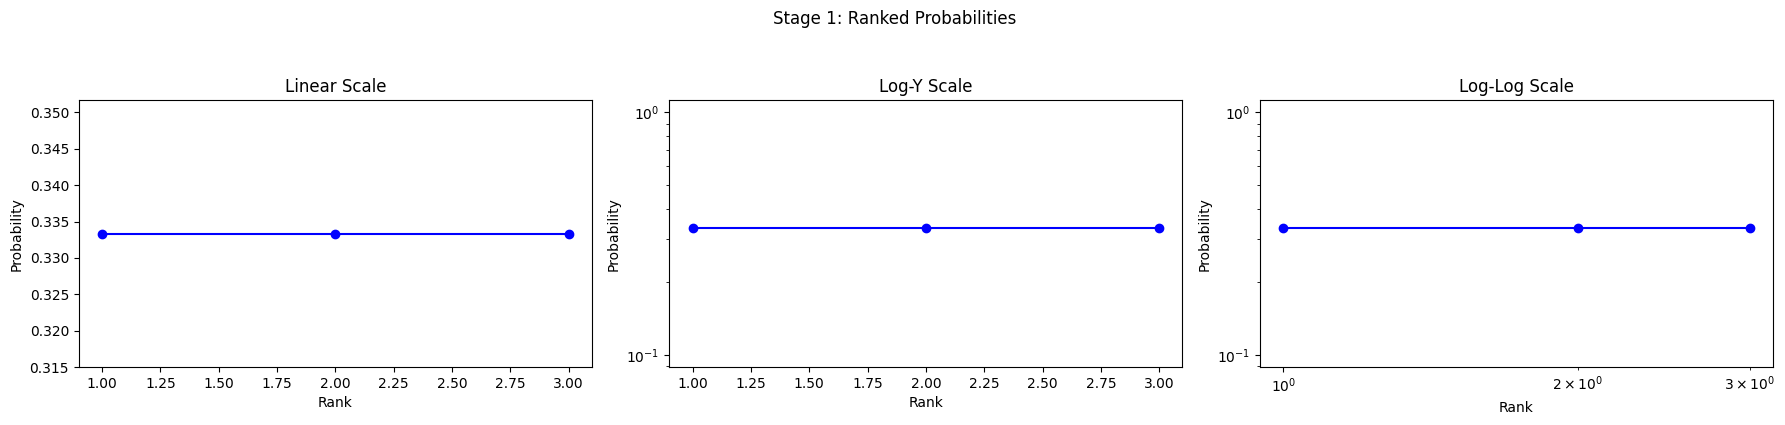

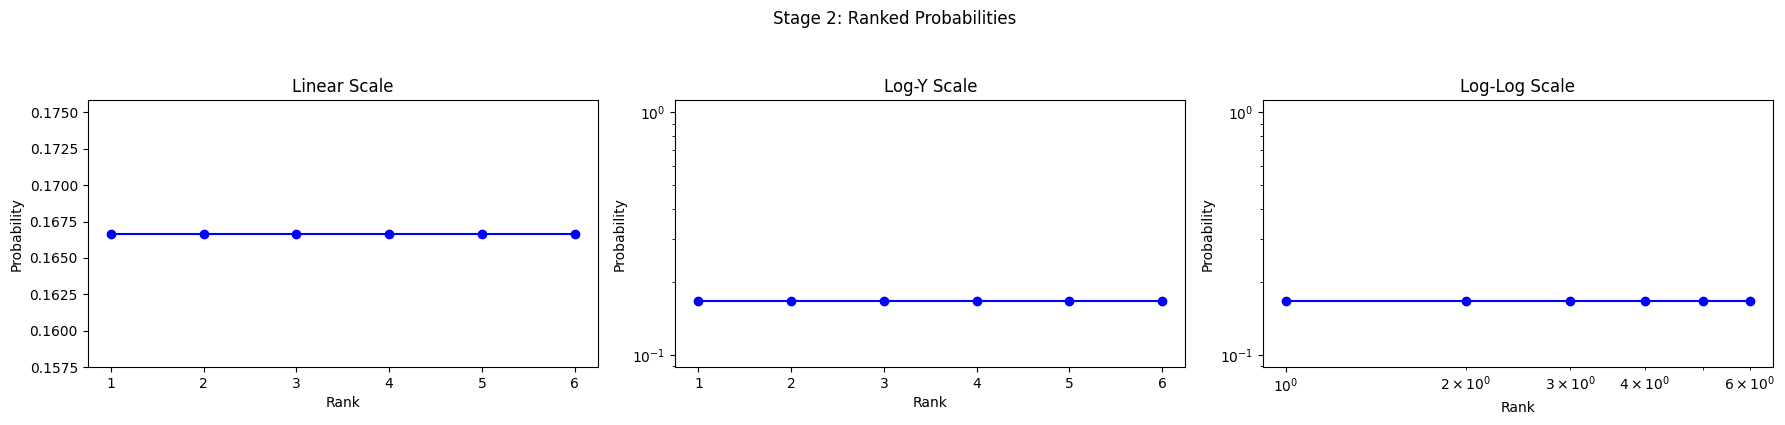

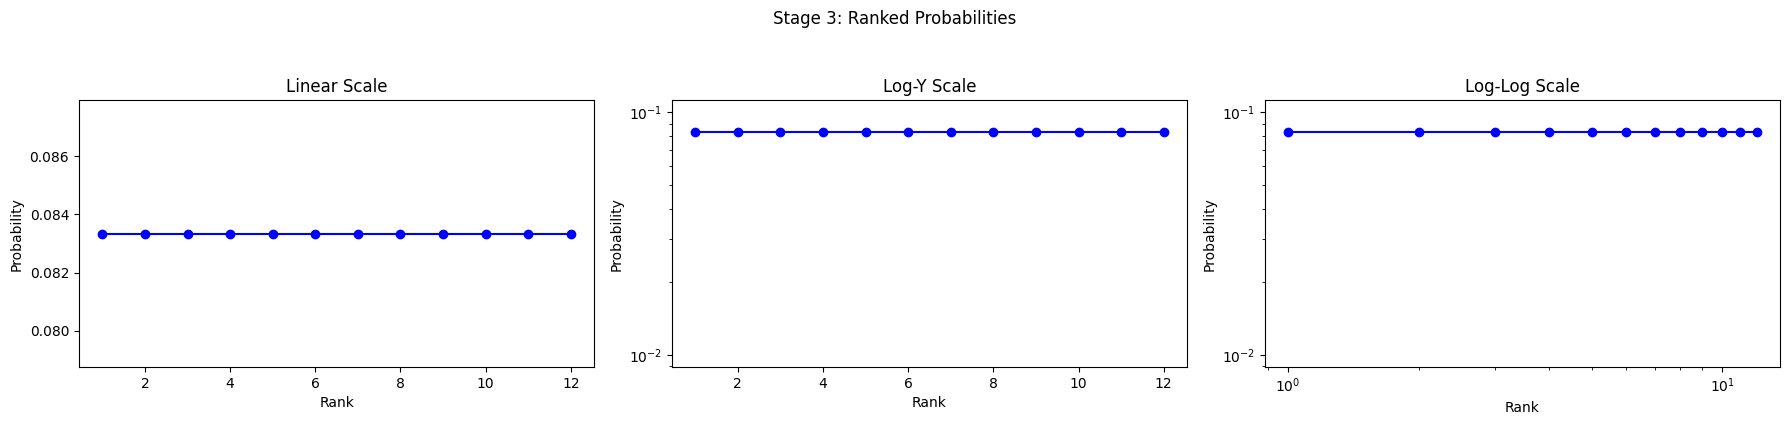

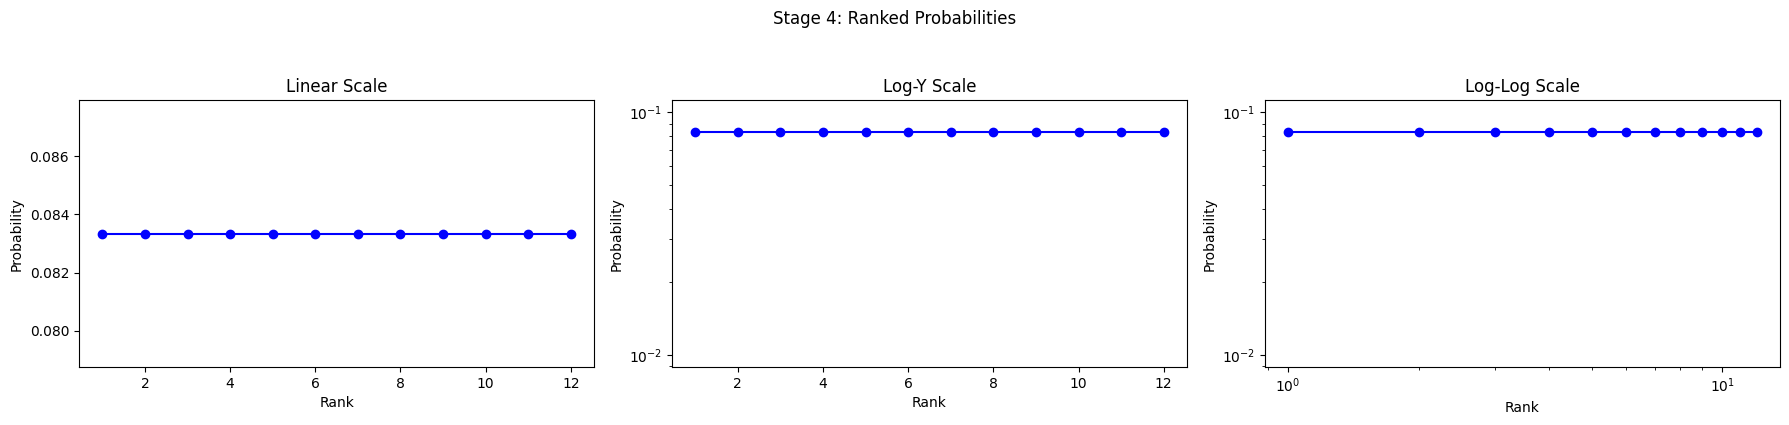

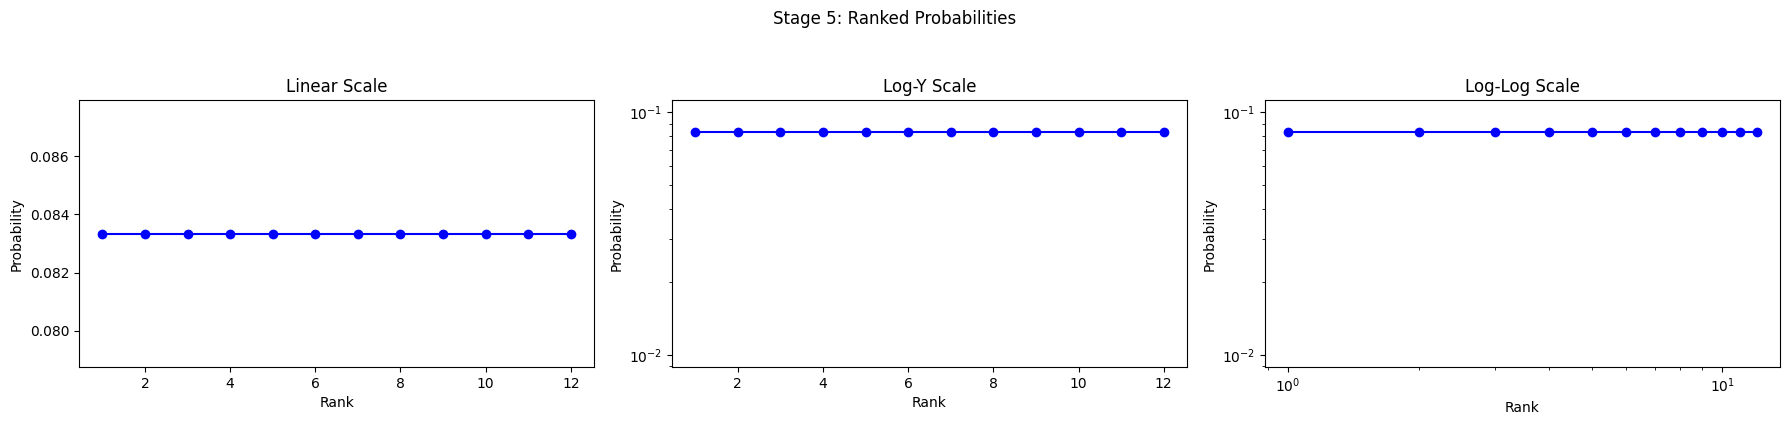

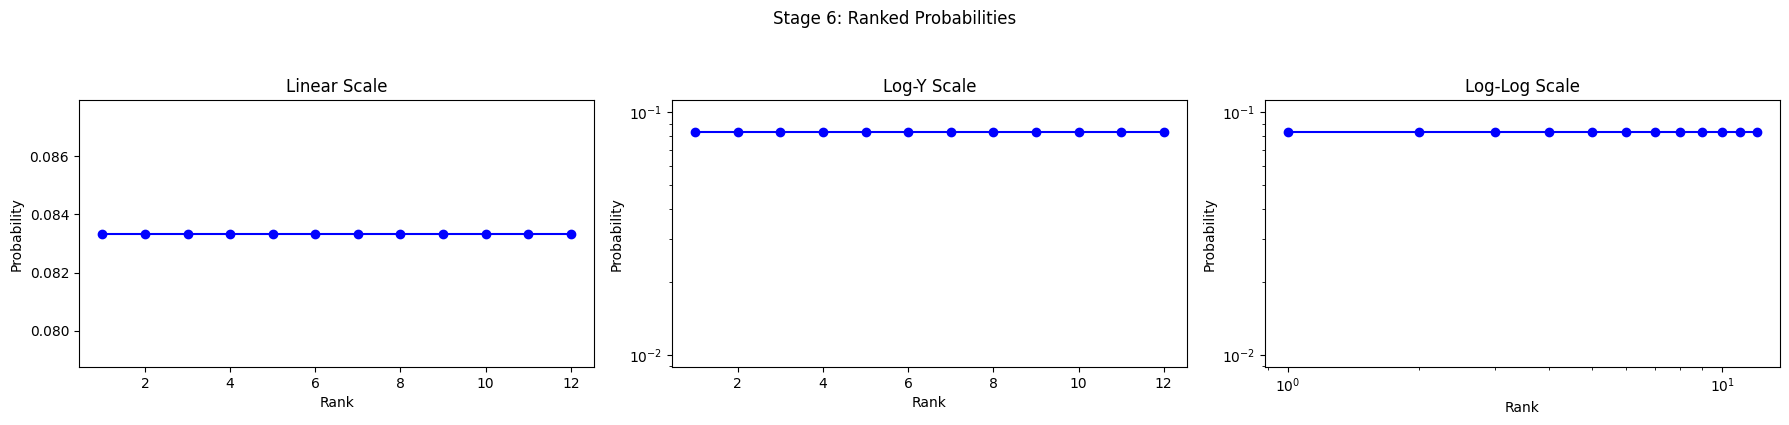

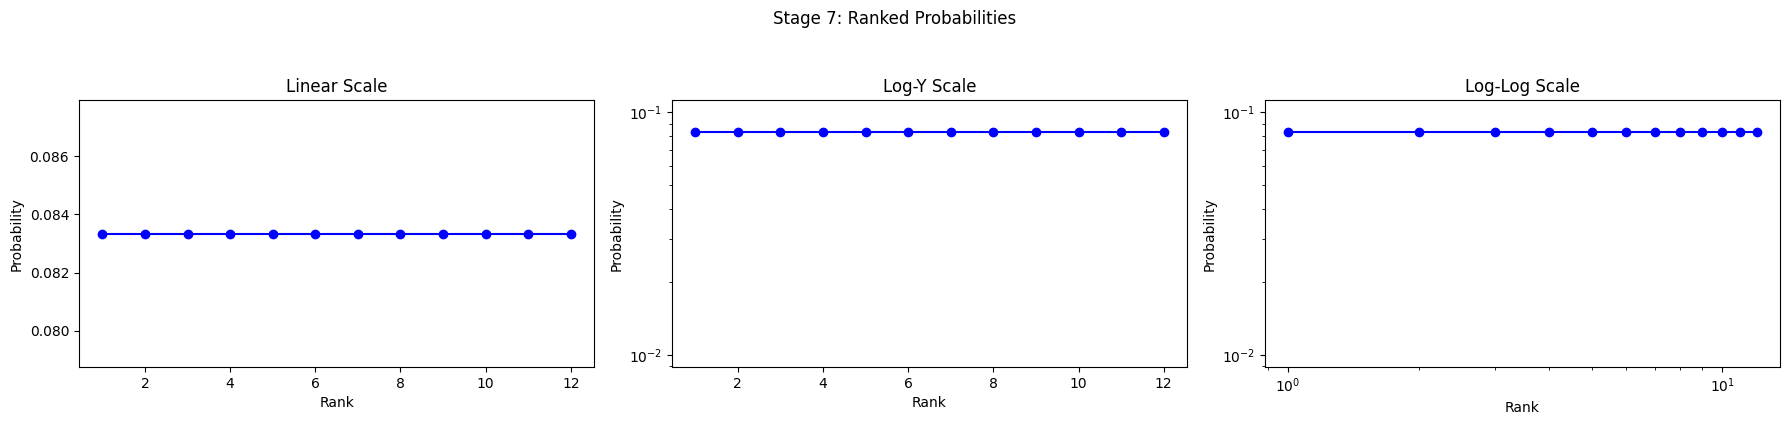

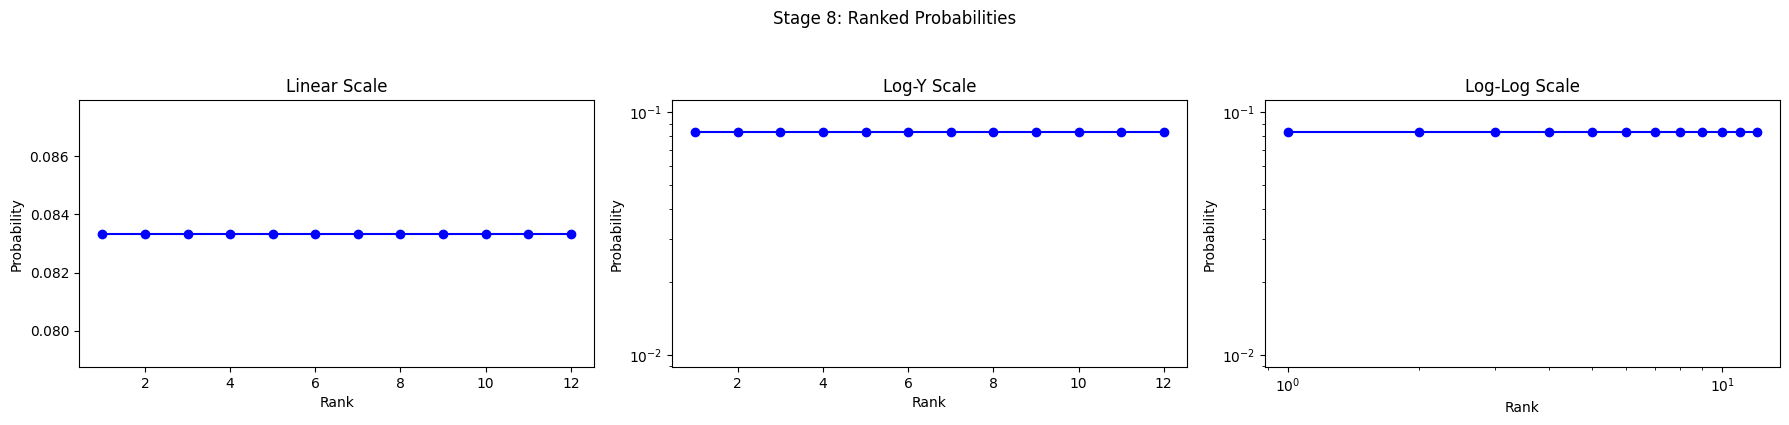

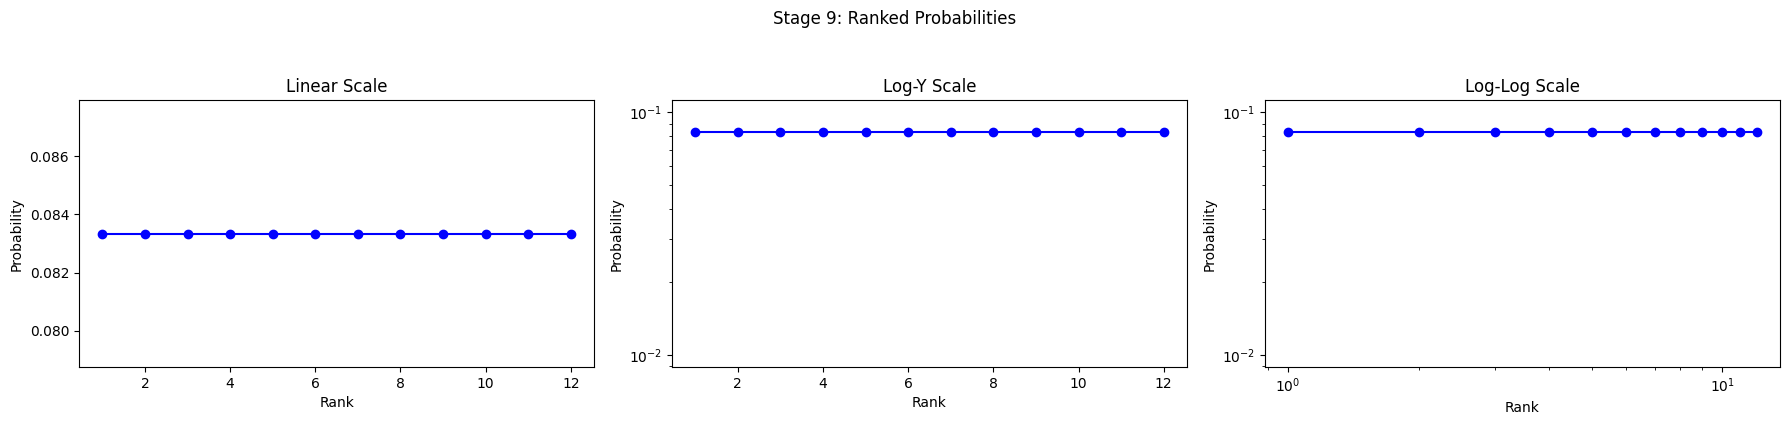

In [43]:

print("Reverse starts here")
for i in range(1):
    DNA_sequence_2 = list(random.choice(list(outcome_lists_1[-1].keys())))
    pairs_pool_2=[(['A','GAMMA'],['B','ALPHA']),(['B','GAMMA'],['A','BETA'])]
    outcome_lists_2= run_probability_calculation_and_plot_IS110(DNA_sequence_2,pairs_pool_2,numberofevents=10, plot=1,rank=1)



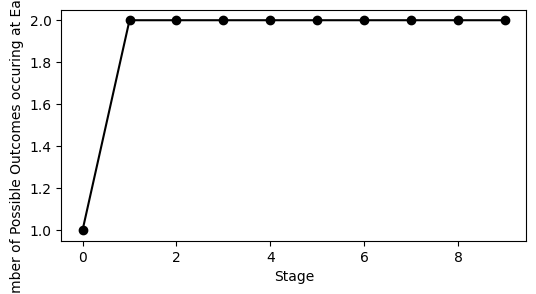

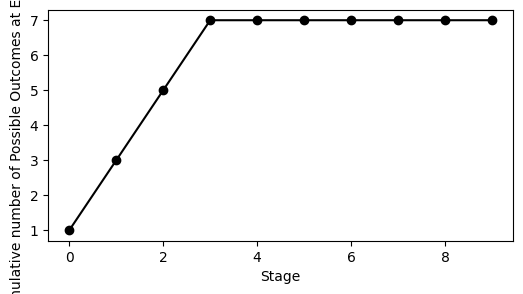

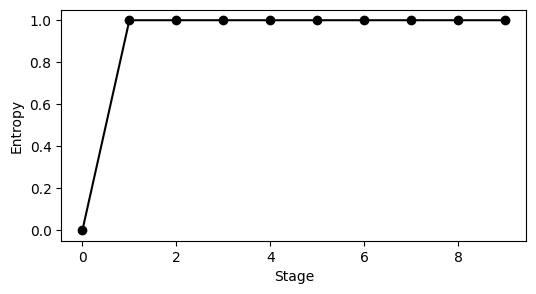

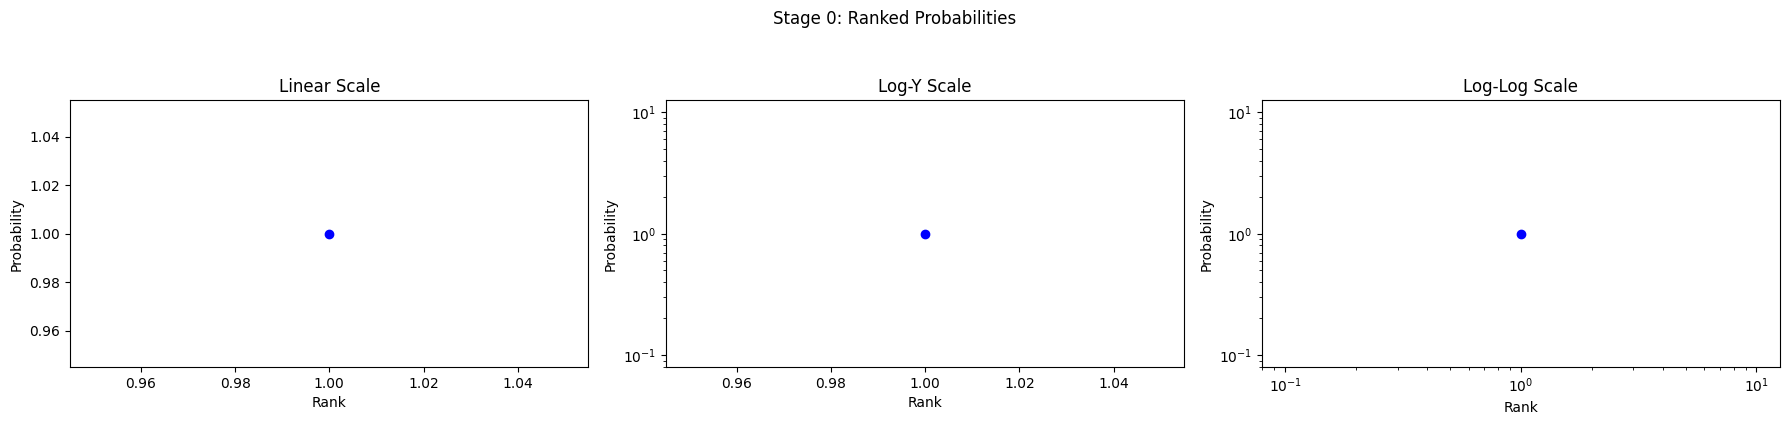

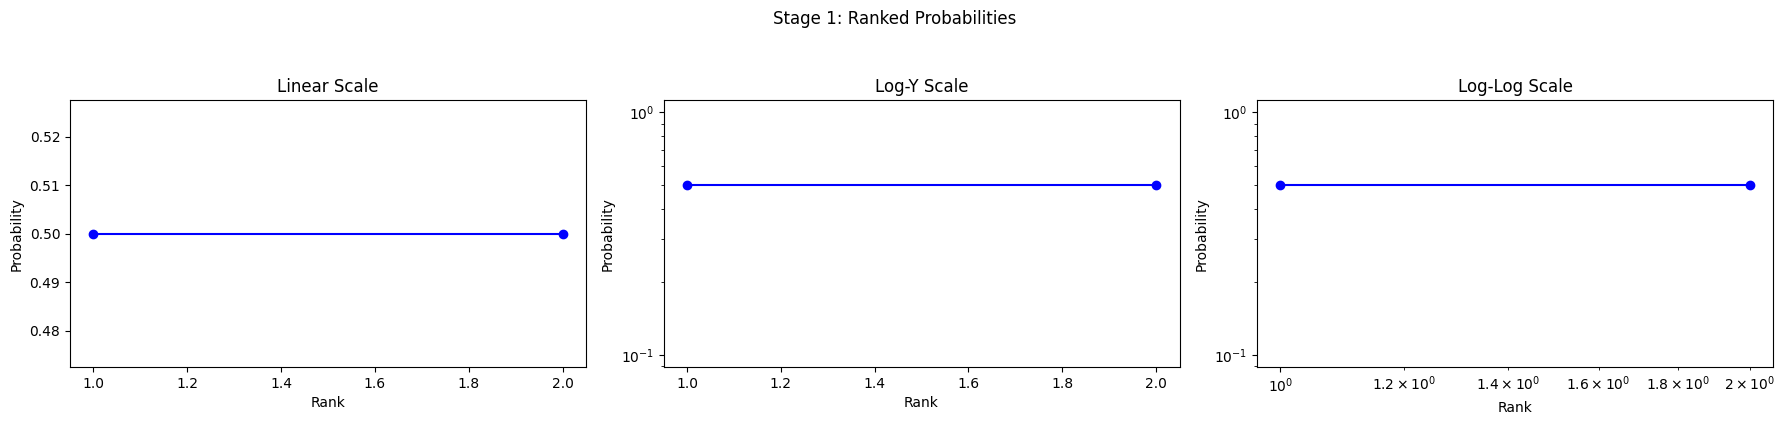

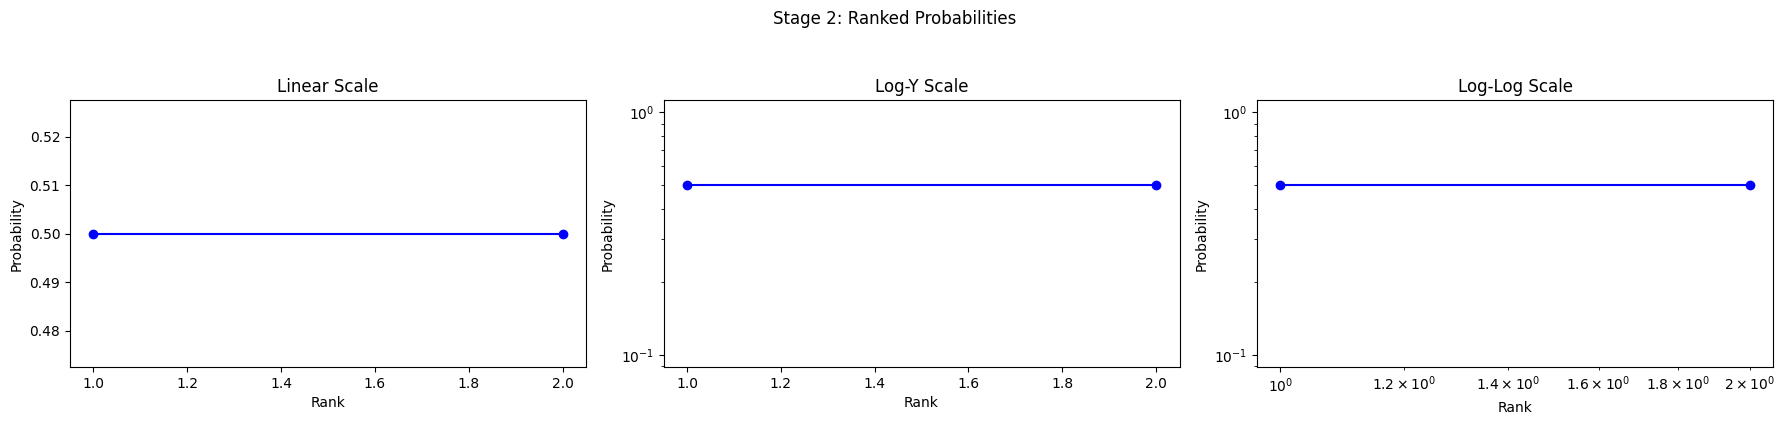

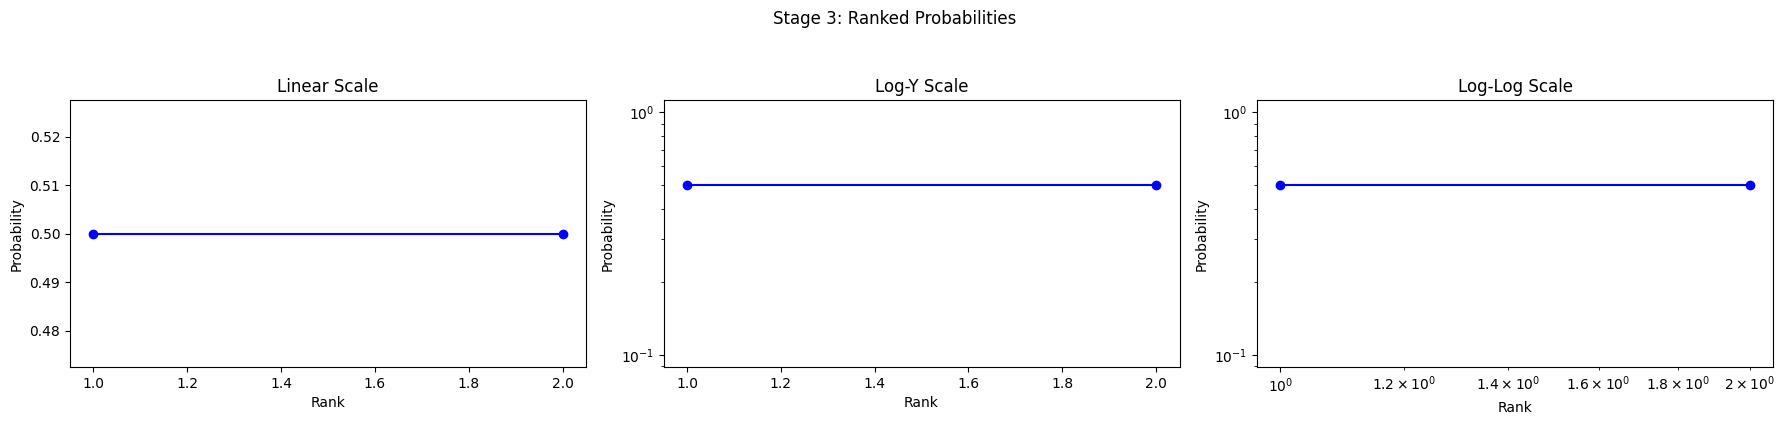

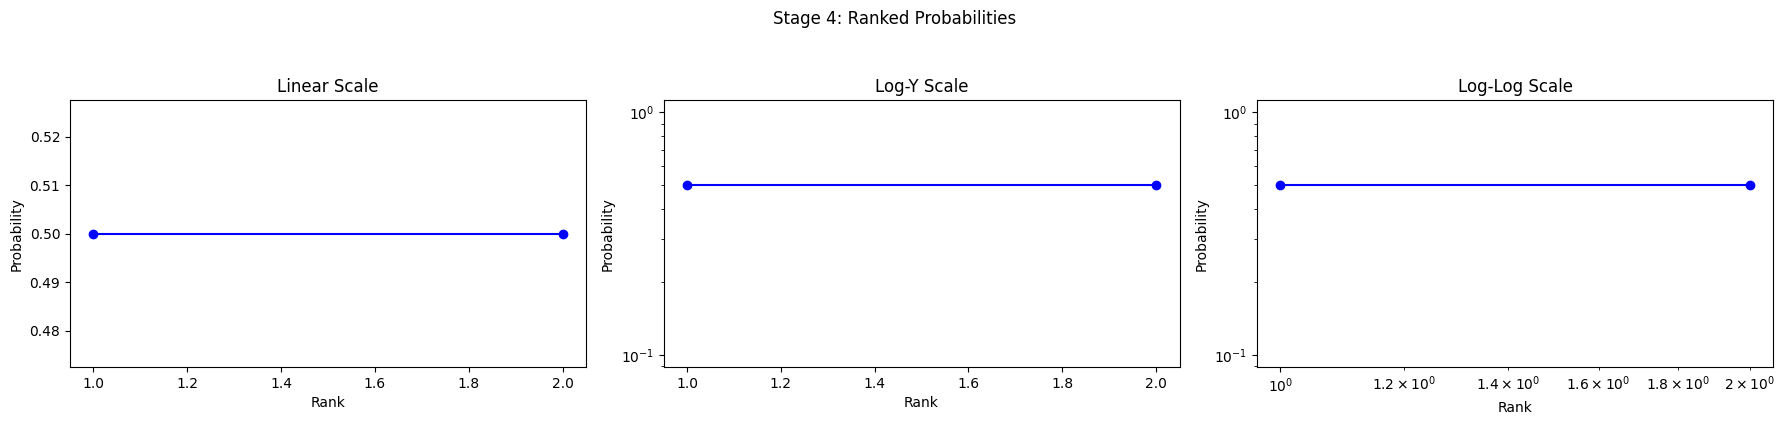

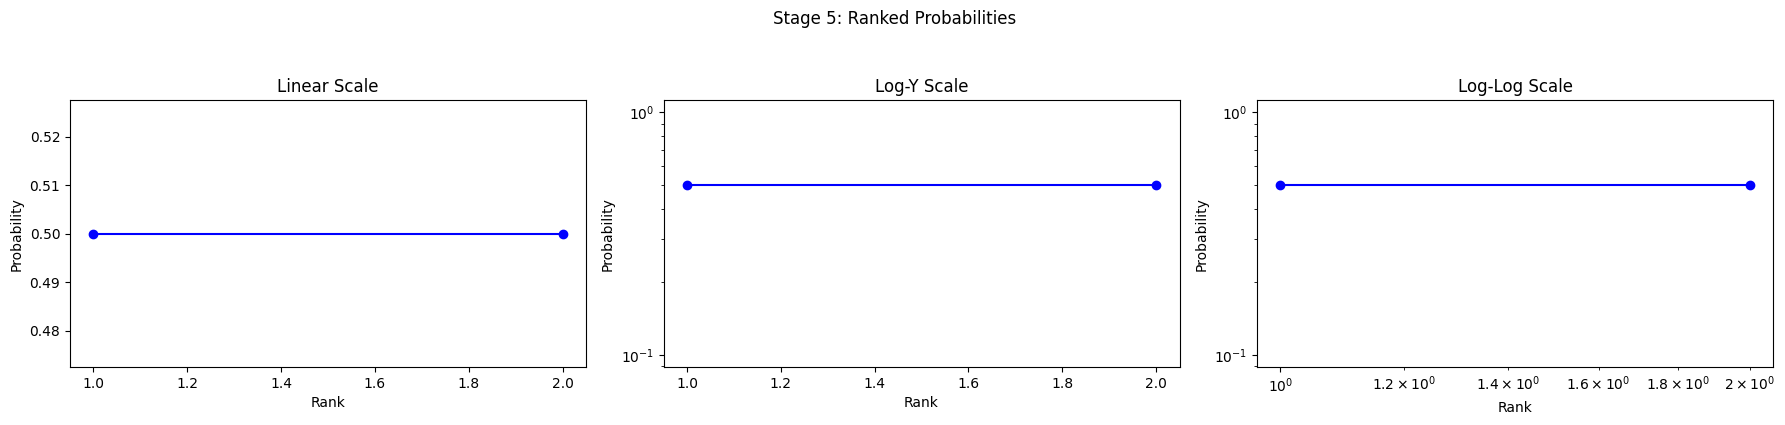

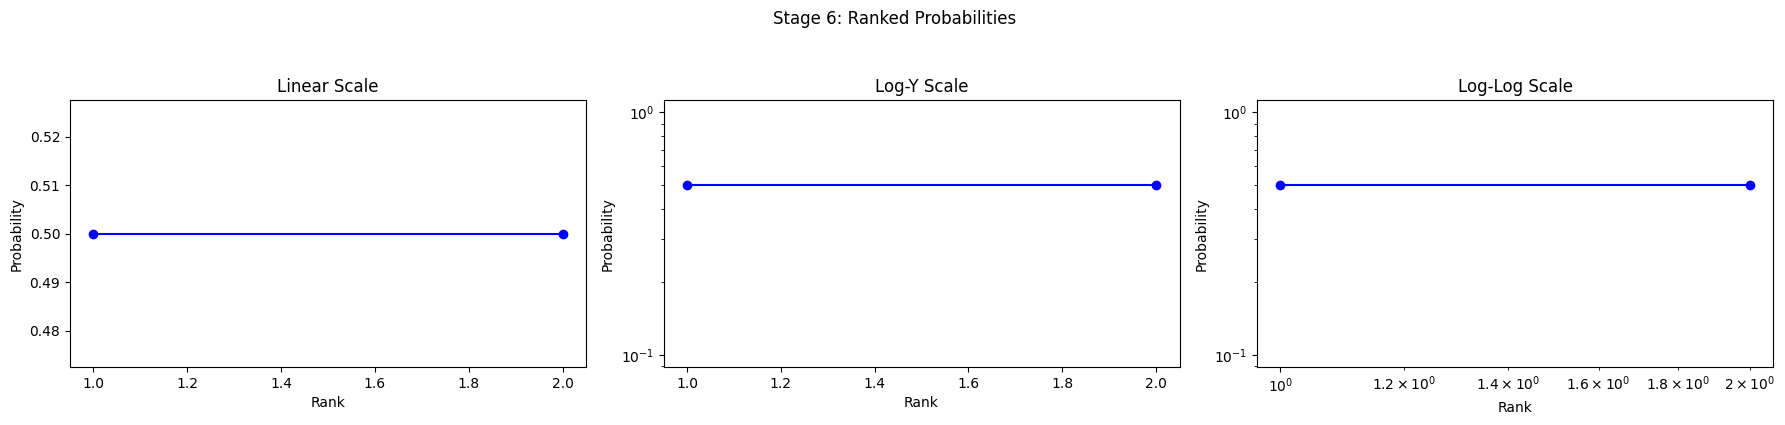

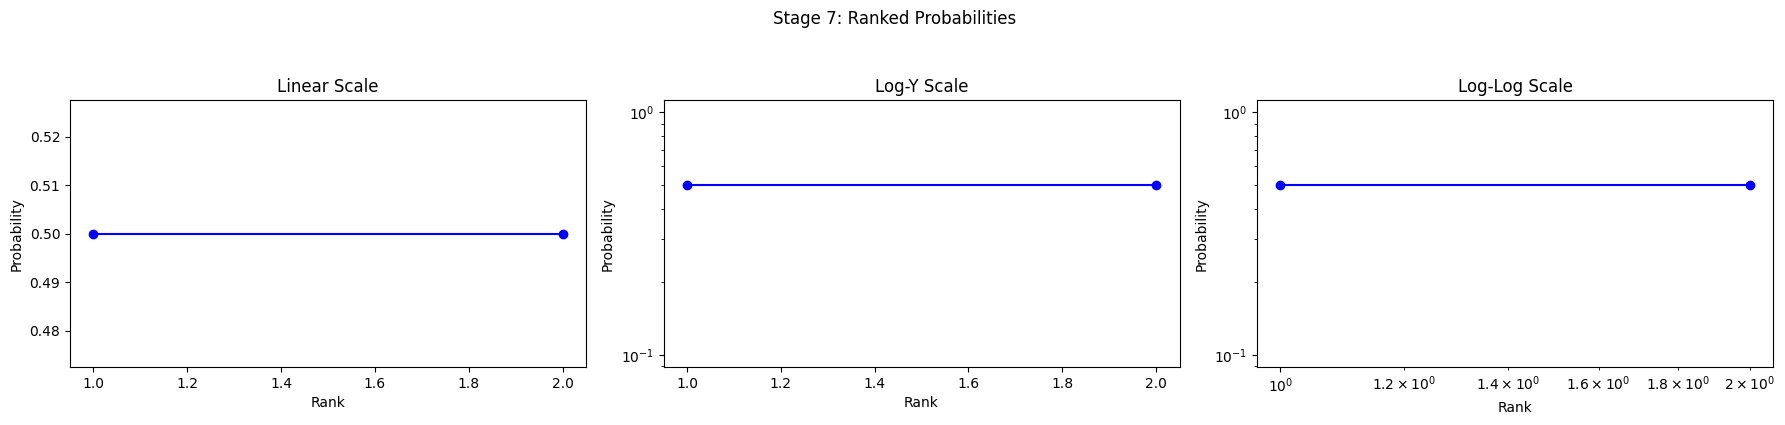

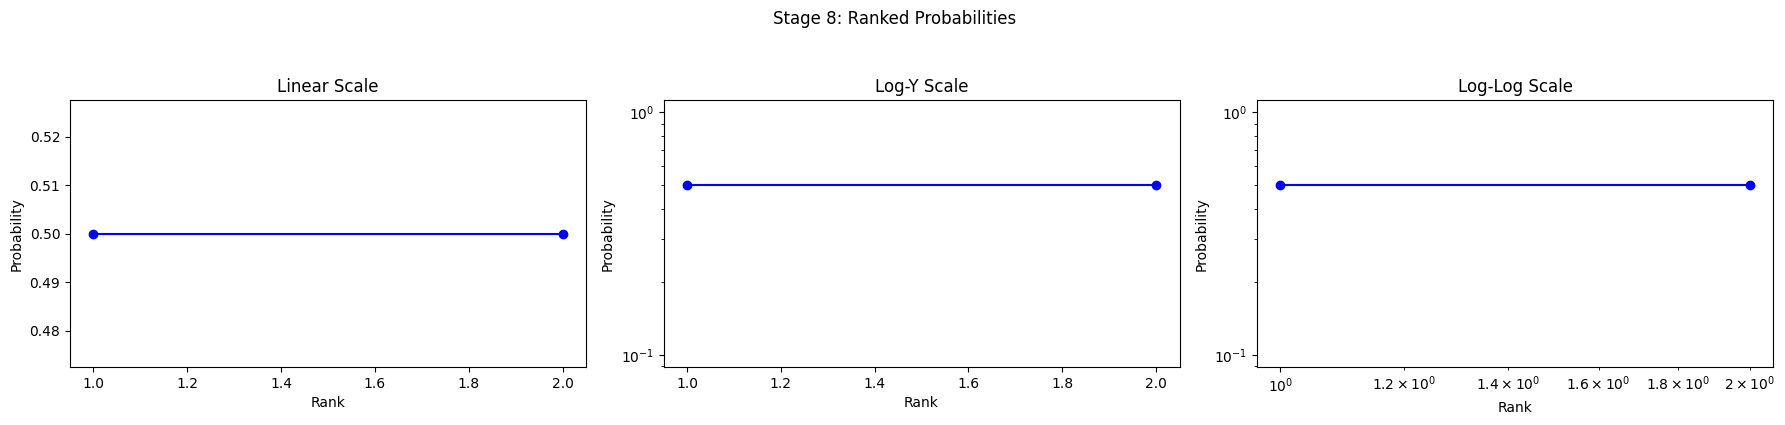

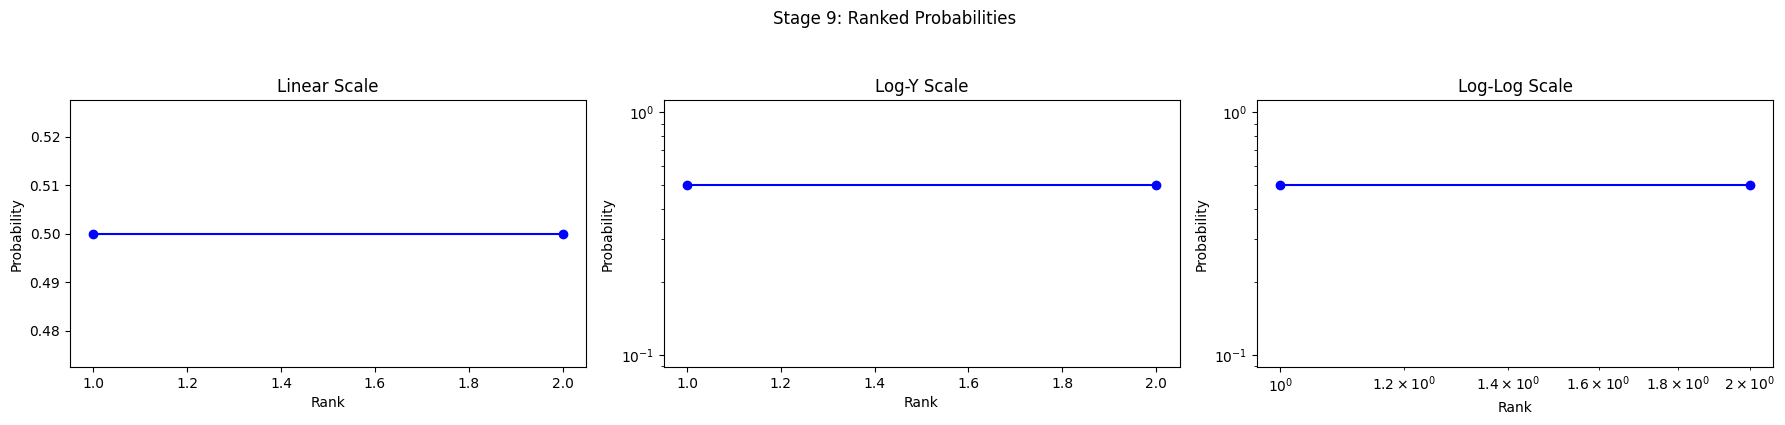

In [44]:

DNA_sequence_3 = list(random.choice(list(outcome_lists_2[-1].keys())))
pairs_pool_3=[(['A','GAMMA'],['B','BETA']),(['B','GAMMA'],['A','ALPHA'])]
outcome_lists_3= run_probability_calculation_and_plot_IS110(DNA_sequence_3,pairs_pool_3,numberofevents=10, plot=1,rank=1)


('THREE', 'A', 'GAMMA', 'four', 'alpha', 'c', 'FIVE', 'delta', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f')
('THREE', 'A', 'DELTA', 'five', 'C', 'GAMMA', 'four', 'alpha', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f')
('THREE', 'A', 'EPSILON', 'six', 'D', 'DELTA', 'five', 'C', 'GAMMA', 'four', 'alpha', 'e', 'SEVEN', 'zeta', 'f')
('THREE', 'A', 'ZETA', 'seven', 'E', 'EPSILON', 'six', 'D', 'DELTA', 'five', 'C', 'GAMMA', 'four', 'alpha', 'f')
('THREE', 'A', 'GAMMA', 'four', 'alpha', 'c', 'FIVE', 'delta', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f') Terminal state reached, no recombinase acted
('THREE', 'A', 'DELTA', 'five', 'C', 'GAMMA', 'four', 'alpha', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f') Terminal state reached, no recombinase acted
('THREE', 'A', 'EPSILON', 'six', 'D', 'DELTA', 'five', 'C', 'GAMMA', 'four', 'alpha', 'e', 'SEVEN', 'zeta', 'f') Terminal state reached, no recombinase acted
('THREE', 'A', 'ZETA', 'seven', 'E', 'EPSILON', 'six', 'D', 'DELTA', 'five

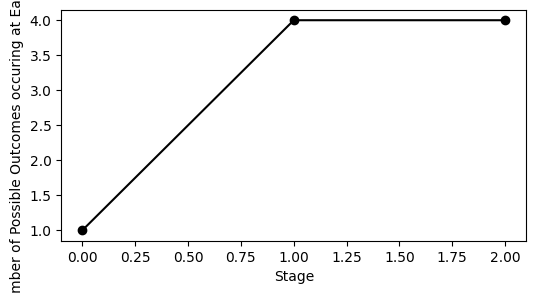

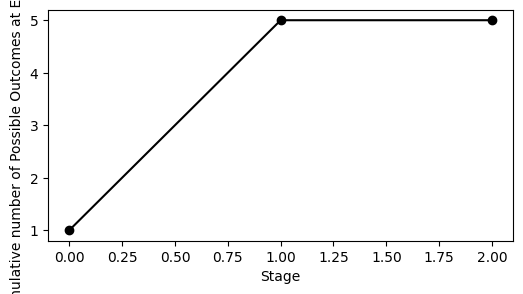

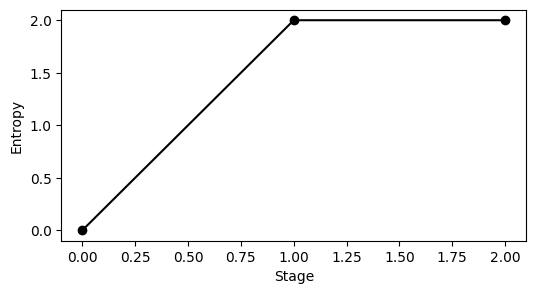

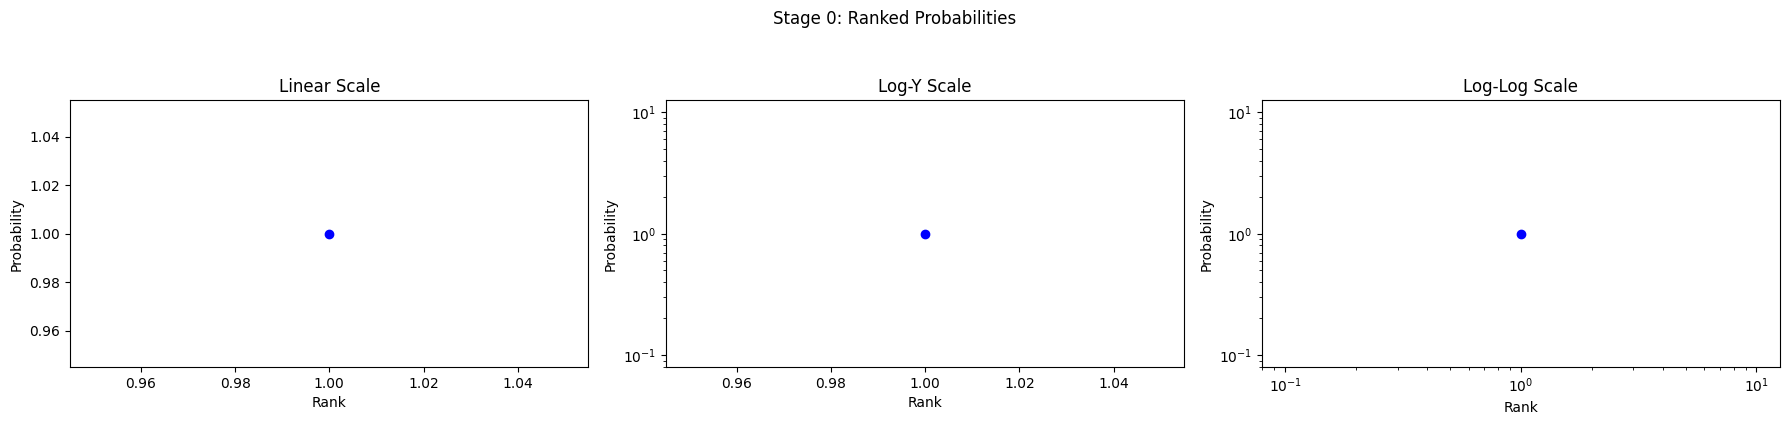

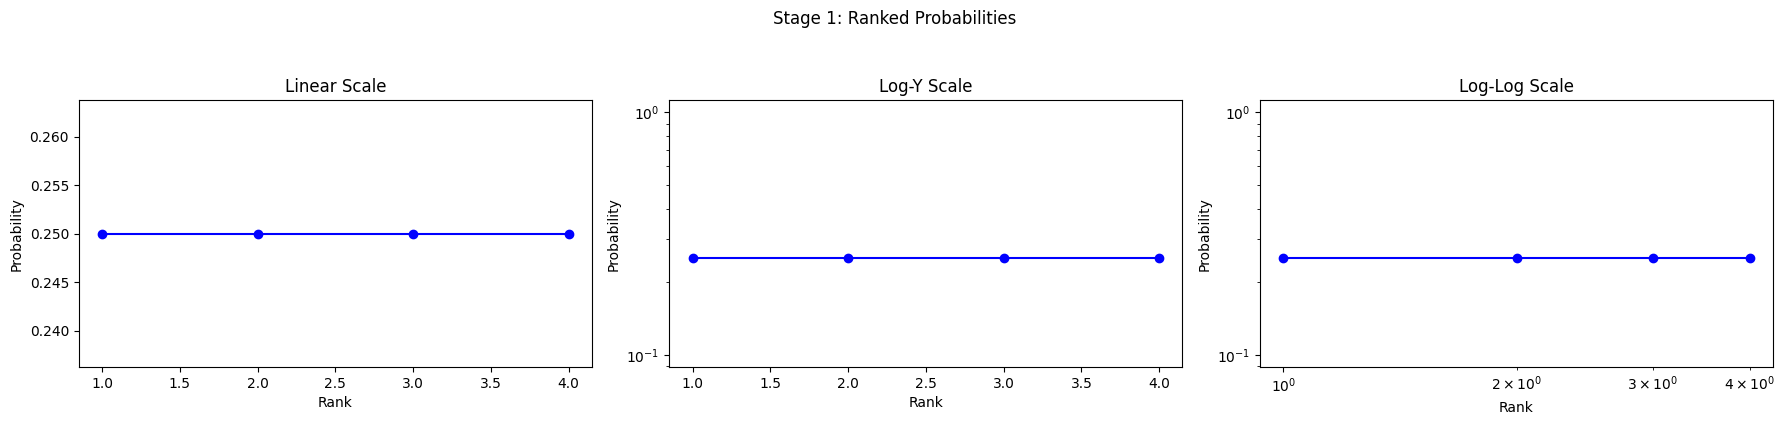

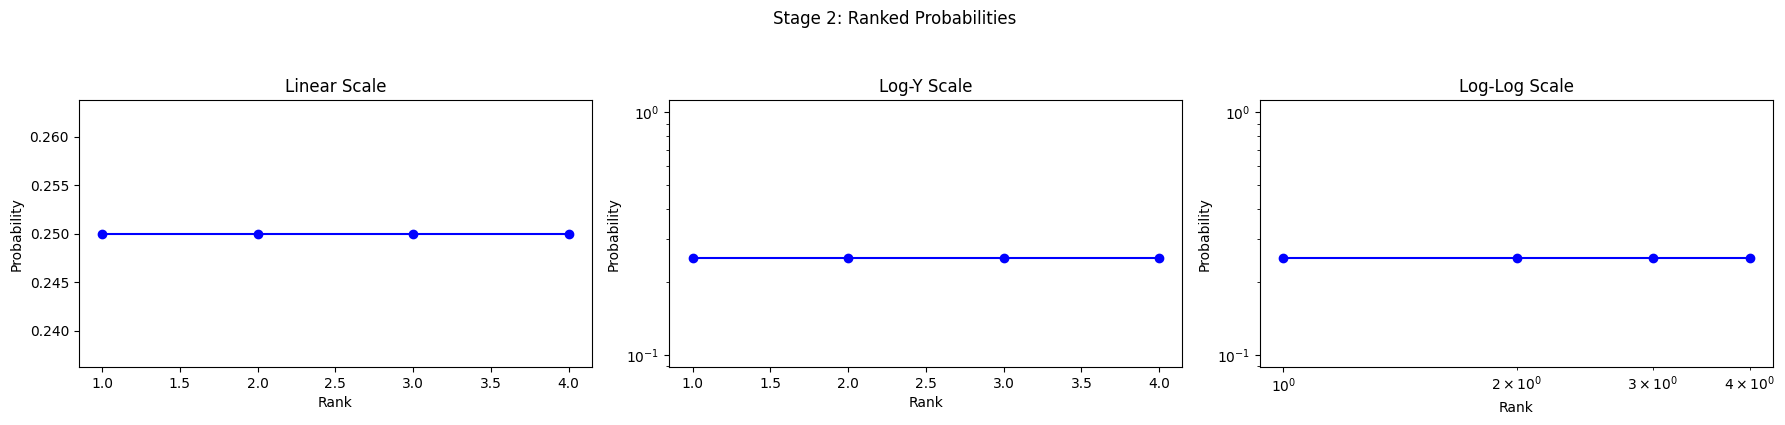

In [45]:
#An attempt of reversable sequence
DNA_sequence_re=[
#'ONE', 'A', 'ALPHA',
#'TWO','A','ALPHA',
'THREE', 'A', 'ALPHA',

'FOUR','gamma', 'c',
'FIVE','delta', 'd',
'SIX','epsilon', 'e',
'SEVEN','zeta', 'f',
]
pairs_pool_re=[(['A','ALPHA'],['C','GAMMA']),(['A','ALPHA'],['D','DELTA']),(['A','ALPHA'],['E','EPSILON']),(['A','ALPHA'],['F','ZETA'])]
outcome_lists_re= run_probability_calculation_and_plot_IS110(DNA_sequence_re,pairs_pool_re,numberofevents=3,plot=1,rank=1,print_output=1,print_T=1)


In [46]:
pairs_pool=[(['A','BETA'],['B','ALPHA']),(['A','GAMMA'],['C','ALPHA']),(['A','DELTA'],['D','ALPHA']),(['A','EPSILON'],['E','ALPHA']),(['A','ZETA'],['F','ALPHA'])]
for i in outcome_lists_re[-1].keys():
    temp=run_probability_calculation_and_plot_IS110(i,pairs_pool,numberofevents=2,plot=0)
    print(temp[-1])


Counter({('THREE', 'A', 'ALPHA', 'FOUR', 'gamma', 'c', 'FIVE', 'delta', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f'): 1.0})
Counter({('THREE', 'A', 'ALPHA', 'FOUR', 'gamma', 'c', 'FIVE', 'delta', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f'): 1.0})
Counter({('THREE', 'A', 'ALPHA', 'FOUR', 'gamma', 'c', 'FIVE', 'delta', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f'): 1.0})
Counter({('THREE', 'A', 'ALPHA', 'FOUR', 'gamma', 'c', 'FIVE', 'delta', 'd', 'SIX', 'epsilon', 'e', 'SEVEN', 'zeta', 'f'): 1.0})


In [47]:
DNA_sequence_4 = [
'ONE', 'A', 'ALPHA',
'TWO','beta','b',
'THREE','gamma','c',
'FOUR','omega','z',
'FIVE','omega','z',
'SIX','omega','z',
]
pairs_pool_4=[(['A','ALPHA'],['B','BETA']),(['A','ALPHA'],['C','GAMMA']),
              (['A','BETA'],['Z','OMEGA']),(['A','GAMMA'],['Z','OMEGA'])]
outcome_list_4=run_probability_calculation_and_plot_IS110(DNA_sequence_4,pairs_pool_4,numberofevents=3,plot=0,rank=1,print_output=1,print_T=1)

('ONE', 'A', 'BETA', 'two', 'alpha', 'b', 'THREE', 'gamma', 'c', 'FOUR', 'omega', 'z', 'FIVE', 'omega', 'z', 'SIX', 'omega', 'z')
('ONE', 'A', 'GAMMA', 'three', 'B', 'BETA', 'two', 'alpha', 'c', 'FOUR', 'omega', 'z', 'FIVE', 'omega', 'z', 'SIX', 'omega', 'z')
('ONE', 'A', 'OMEGA', 'four', 'C', 'GAMMA', 'three', 'B', 'ALPHA', 'TWO', 'beta', 'z', 'FIVE', 'omega', 'z', 'SIX', 'omega', 'z')
('ONE', 'A', 'OMEGA', 'five', 'Z', 'OMEGA', 'four', 'C', 'GAMMA', 'three', 'B', 'ALPHA', 'TWO', 'beta', 'z', 'SIX', 'omega', 'z')
('ONE', 'A', 'OMEGA', 'six', 'Z', 'OMEGA', 'five', 'Z', 'OMEGA', 'four', 'C', 'GAMMA', 'three', 'B', 'ALPHA', 'TWO', 'beta', 'z')
('ONE', 'A', 'OMEGA', 'four', 'C', 'ALPHA', 'TWO', 'beta', 'b', 'THREE', 'gamma', 'z', 'FIVE', 'omega', 'z', 'SIX', 'omega', 'z')
('ONE', 'A', 'OMEGA', 'five', 'Z', 'OMEGA', 'four', 'C', 'ALPHA', 'TWO', 'beta', 'b', 'THREE', 'gamma', 'z', 'SIX', 'omega', 'z')
('ONE', 'A', 'OMEGA', 'six', 'Z', 'OMEGA', 'five', 'Z', 'OMEGA', 'four', 'C', 'ALPHA', 'TW

In [48]:
pairs_pool_5=[(['A','BETA'],['B','ALPHA']),(['A','GAMMA'],['C','ALPHA']),
              (['A','OMEGA'],['Z','BETA']),(['A','OMEGA'],['Z','GAMMA'])]
final_outcome=Counter()
for i in outcome_list_4[-1].keys():
    temp=run_probability_calculation_and_plot_IS110(i,pairs_pool_5,numberofevents=3,plot=0)
    final_outcome.update(temp[-1])
print(f'All reverts back to the original list {list(final_outcome.keys())==[(
                                                                                'ONE', 'A', 'ALPHA',
                                                                                'TWO','beta','b',
                                                                                'THREE','gamma','c',
                                                                                'FOUR','omega','z',
                                                                                'FIVE','omega','z',
                                                                                'SIX','omega','z')]}')



All reverts back to the original list True


In [49]:
#Unique order state machine: The initial sequence has sites ABCD… We write a rule s.t A-B is a valid pair. The product created by the reaction of A-B is called AB. AB-C is a valid pair. BC-E is a valid pair…